# Optimización de las actuaciones del cuerpo de bomberos

#### Autores: Alejandro Rasero, Junhao Ge

***

En este notebook se especificarán todos los procesos de análisis que se han realizado para obtener los resultados esperados.

Como se ha comentado previamente, se pretende:
- Realizar un estudio de estacionalidad
- Buscar relaciones entre los cuerpos de Bomberos, Policía y SAMUR
- Predicción de los cuerpos
- Considerar variables exógenas
- Comprobar si las previsiones que esperábamos eran ciertas

La expicación detallada se puede encontrar en el archivo pdf que se ha entregado junto al ipynb, o en su defecto en el repositorio de Github _"https://github.com/Junhao42/Estudio-y-optimizacion-de-las-actuaciones-de-bomberos-de-la-comunidad-de-Madrid"_

***

Importamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings


import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa import ar_model


# Comando para instalar la librería en caso de no tenerla instalada previamente
# pip install pmdarima

import pmdarima as pm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats.distributions import chi2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
warnings.filterwarnings("ignore")

# Carga de datos de bomberos

La primera celda se usa para juntar los .csv de cada año. Tras ello, se guardan en un nuevo csv. Esta celda esta comentada para evitar repeticiones, si disponemos del csv completo no es necesario ejecutar esta celda

In [3]:
# ruta = './bomberos/ActuacionesBomberos_'
# fechas = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
# dataframes = []

# encoding='ISO-8859-1'

# for fecha in fechas:
#     df = pd.read_csv(ruta+fecha+'.csv', sep=';', skiprows=0, encoding=encoding)

#     dataframes.append(df)
#     if fecha == '2019':
#         encoding='utf-8'
    
# bomberos = pd.concat(dataframes, ignore_index=True)
# bomberos.dropna(inplace=True)
# bomberos

In [4]:
# bomberos.to_csv('./bomberos/bomberos_completo.csv', index=False)

In [5]:
bomberos = pd.read_csv('./bomberos/bomberos_completo.csv', sep=',', skiprows=0, encoding='utf-8')

bomberos

AÑO     MES                     DISTRITO  FUEGOS  \
0     2017  Agosto                       CENTRO    47.0   
1     2017  Agosto                   ARGANZUELA    24.0   
2     2017  Agosto                       RETIRO    11.0   
3     2017  Agosto                    SALAMANCA    19.0   
4     2017  Agosto                    CHAMARTIN    15.0   
...    ...     ...                          ...     ...   
1617  2023   enero            VILLA DE VALLECAS    15.0   
1618  2023   enero                    VICALVARO     9.0   
1619  2023   enero                     SAN BLAS    16.0   
1620  2023   enero                      BARAJAS     1.0   
1621  2023   enero  FUERA DEL TÉRMINO MUNICIPAL     0.0   

      DAÑOS EN CONSTRUCCION  SALVAMENTOS Y RESCATES  DAÑOS POR AGUA  \
0                      20.0                    44.0            26.0   
1                       5.0                    20.0            15.0   
2                       7.0                    12.0             9.0   
3                      12.0                    20.0            17.0   
4                       6.0                    21.0             8.0   
...                     ...                     ...             ...   
1617                    7.0                    19.0             5.0   
1618                    5.0                     8.0             3.0   
1619                    3.0                    25.0             4.0   
1620                    2.0                     4.0             2.0   
1621                    0.0                     0.0             0.0   

      INCIDENTES DIVERSOS  SALIDAS SIN INTERVENCION  SERVICIOS VARIOS  TOTAL  
0                    34.0                      19.0               9.0  199.0  
1                    28.0                      13.0               3.0  108.0  
2                    30.0                       3.0               1.0   73.0  
3                    32.0                       4.0               1.0  105.0  
4                    34.0                      11.0               2.0   97.0  
...                   ...                       ...               ...    ...  
1617                  7.0                      22.0               2.0   77.0  
1618                  8.0                       6.0               2.0   41.0  
1619                 10.0                      20.0               1.0   79.0  
1620                 15.0                      13.0               8.0   45.0  
1621                  2.0                       1.0               0.0    3.0  

[1622 rows x 11 columns]

In [6]:
bomberos['MES'] = bomberos['MES'].str.lower()

In [7]:
bomberos['MES'].value_counts()

octubre       154
agosto        151
septiembre    151
abril         132
mayo          131
diciembre     130
febrero       130
junio         130
julio         130
noviembre     128
marzo         128
enero         127
Name: MES, dtype: int64

In [8]:
bomberos.dropna()

AÑO     MES                     DISTRITO  FUEGOS  \
0     2017  agosto                       CENTRO    47.0   
1     2017  agosto                   ARGANZUELA    24.0   
2     2017  agosto                       RETIRO    11.0   
3     2017  agosto                    SALAMANCA    19.0   
4     2017  agosto                    CHAMARTIN    15.0   
...    ...     ...                          ...     ...   
1617  2023   enero            VILLA DE VALLECAS    15.0   
1618  2023   enero                    VICALVARO     9.0   
1619  2023   enero                     SAN BLAS    16.0   
1620  2023   enero                      BARAJAS     1.0   
1621  2023   enero  FUERA DEL TÉRMINO MUNICIPAL     0.0   

      DAÑOS EN CONSTRUCCION  SALVAMENTOS Y RESCATES  DAÑOS POR AGUA  \
0                      20.0                    44.0            26.0   
1                       5.0                    20.0            15.0   
2                       7.0                    12.0             9.0   
3                      12.0                    20.0            17.0   
4                       6.0                    21.0             8.0   
...                     ...                     ...             ...   
1617                    7.0                    19.0             5.0   
1618                    5.0                     8.0             3.0   
1619                    3.0                    25.0             4.0   
1620                    2.0                     4.0             2.0   
1621                    0.0                     0.0             0.0   

      INCIDENTES DIVERSOS  SALIDAS SIN INTERVENCION  SERVICIOS VARIOS  TOTAL  
0                    34.0                      19.0               9.0  199.0  
1                    28.0                      13.0               3.0  108.0  
2                    30.0                       3.0               1.0   73.0  
3                    32.0                       4.0               1.0  105.0  
4                    34.0                      11.0               2.0   97.0  
...                   ...                       ...               ...    ...  
1617                  7.0                      22.0               2.0   77.0  
1618                  8.0                       6.0               2.0   41.0  
1619                 10.0                      20.0               1.0   79.0  
1620                 15.0                      13.0               8.0   45.0  
1621                  2.0                       1.0               0.0    3.0  

[1622 rows x 11 columns]

In [9]:
# Pasamos los meses a números
meses = {'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12}
bomberos['MES'] = bomberos['MES'].map(meses).astype(int)

In [10]:
bomberos

AÑO  MES                     DISTRITO  FUEGOS  DAÑOS EN CONSTRUCCION  \
0     2017    8                       CENTRO    47.0                   20.0   
1     2017    8                   ARGANZUELA    24.0                    5.0   
2     2017    8                       RETIRO    11.0                    7.0   
3     2017    8                    SALAMANCA    19.0                   12.0   
4     2017    8                    CHAMARTIN    15.0                    6.0   
...    ...  ...                          ...     ...                    ...   
1617  2023    1            VILLA DE VALLECAS    15.0                    7.0   
1618  2023    1                    VICALVARO     9.0                    5.0   
1619  2023    1                     SAN BLAS    16.0                    3.0   
1620  2023    1                      BARAJAS     1.0                    2.0   
1621  2023    1  FUERA DEL TÉRMINO MUNICIPAL     0.0                    0.0   

      SALVAMENTOS Y RESCATES  DAÑOS POR AGUA  INCIDENTES DIVERSOS  \
0                       44.0            26.0                 34.0   
1                       20.0            15.0                 28.0   
2                       12.0             9.0                 30.0   
3                       20.0            17.0                 32.0   
4                       21.0             8.0                 34.0   
...                      ...             ...                  ...   
1617                    19.0             5.0                  7.0   
1618                     8.0             3.0                  8.0   
1619                    25.0             4.0                 10.0   
1620                     4.0             2.0                 15.0   
1621                     0.0             0.0                  2.0   

      SALIDAS SIN INTERVENCION  SERVICIOS VARIOS  TOTAL  
0                         19.0               9.0  199.0  
1                         13.0               3.0  108.0  
2                          3.0               1.0   73.0  
3                          4.0               1.0  105.0  
4                         11.0               2.0   97.0  
...                        ...               ...    ...  
1617                      22.0               2.0   77.0  
1618                       6.0               2.0   41.0  
1619                      20.0               1.0   79.0  
1620                      13.0               8.0   45.0  
1621                       1.0               0.0    3.0  

[1622 rows x 11 columns]

In [11]:
# renombramos la columna de mes

bomberos.rename(columns={'MES': 'Month'}, inplace=True)

# Juntamos el año y el mes en una columna
bomberos.rename(columns={'AÑO': 'Year'}, inplace=True)
bomberos['Day'] = 1
bomberos['fecha'] = pd.to_datetime(bomberos[['Year', 'Month', 'Day']])
bomberos.drop(columns=['Year', 'Month', 'Day'], inplace=True)

In [12]:
bomberos

DISTRITO  FUEGOS  DAÑOS EN CONSTRUCCION  \
0                          CENTRO    47.0                   20.0   
1                      ARGANZUELA    24.0                    5.0   
2                          RETIRO    11.0                    7.0   
3                       SALAMANCA    19.0                   12.0   
4                       CHAMARTIN    15.0                    6.0   
...                           ...     ...                    ...   
1617            VILLA DE VALLECAS    15.0                    7.0   
1618                    VICALVARO     9.0                    5.0   
1619                     SAN BLAS    16.0                    3.0   
1620                      BARAJAS     1.0                    2.0   
1621  FUERA DEL TÉRMINO MUNICIPAL     0.0                    0.0   

      SALVAMENTOS Y RESCATES  DAÑOS POR AGUA  INCIDENTES DIVERSOS  \
0                       44.0            26.0                 34.0   
1                       20.0            15.0                 28.0   
2                       12.0             9.0                 30.0   
3                       20.0            17.0                 32.0   
4                       21.0             8.0                 34.0   
...                      ...             ...                  ...   
1617                    19.0             5.0                  7.0   
1618                     8.0             3.0                  8.0   
1619                    25.0             4.0                 10.0   
1620                     4.0             2.0                 15.0   
1621                     0.0             0.0                  2.0   

      SALIDAS SIN INTERVENCION  SERVICIOS VARIOS  TOTAL      fecha  
0                         19.0               9.0  199.0 2017-08-01  
1                         13.0               3.0  108.0 2017-08-01  
2                          3.0               1.0   73.0 2017-08-01  
3                          4.0               1.0  105.0 2017-08-01  
4                         11.0               2.0   97.0 2017-08-01  
...                        ...               ...    ...        ...  
1617                      22.0               2.0   77.0 2023-01-01  
1618                       6.0               2.0   41.0 2023-01-01  
1619                      20.0               1.0   79.0 2023-01-01  
1620                      13.0               8.0   45.0 2023-01-01  
1621                       1.0               0.0    3.0 2023-01-01  

[1622 rows x 10 columns]

La columna 'SALIDAS SIN INTERVENCIÓN' no aporta información que sea necesaria ya que no se trata de intervenciones sino de patrullas. Por tanto, eliminamos esas intervenciones del recuento final.

In [13]:
bomberos['TOTAL'] = bomberos['TOTAL']-bomberos['SALIDAS SIN INTERVENCION']
bomberos.drop(columns='SALIDAS SIN INTERVENCION')

DISTRITO  FUEGOS  DAÑOS EN CONSTRUCCION  \
0                          CENTRO    47.0                   20.0   
1                      ARGANZUELA    24.0                    5.0   
2                          RETIRO    11.0                    7.0   
3                       SALAMANCA    19.0                   12.0   
4                       CHAMARTIN    15.0                    6.0   
...                           ...     ...                    ...   
1617            VILLA DE VALLECAS    15.0                    7.0   
1618                    VICALVARO     9.0                    5.0   
1619                     SAN BLAS    16.0                    3.0   
1620                      BARAJAS     1.0                    2.0   
1621  FUERA DEL TÉRMINO MUNICIPAL     0.0                    0.0   

      SALVAMENTOS Y RESCATES  DAÑOS POR AGUA  INCIDENTES DIVERSOS  \
0                       44.0            26.0                 34.0   
1                       20.0            15.0                 28.0   
2                       12.0             9.0                 30.0   
3                       20.0            17.0                 32.0   
4                       21.0             8.0                 34.0   
...                      ...             ...                  ...   
1617                    19.0             5.0                  7.0   
1618                     8.0             3.0                  8.0   
1619                    25.0             4.0                 10.0   
1620                     4.0             2.0                 15.0   
1621                     0.0             0.0                  2.0   

      SERVICIOS VARIOS  TOTAL      fecha  
0                  9.0  180.0 2017-08-01  
1                  3.0   95.0 2017-08-01  
2                  1.0   70.0 2017-08-01  
3                  1.0  101.0 2017-08-01  
4                  2.0   86.0 2017-08-01  
...                ...    ...        ...  
1617               2.0   55.0 2023-01-01  
1618               2.0   35.0 2023-01-01  
1619               1.0   59.0 2023-01-01  
1620               8.0   32.0 2023-01-01  
1621               0.0    2.0 2023-01-01  

[1622 rows x 9 columns]

Creamos un dataframe que contenga el número total de actuaciones de bomberos por cada mes en toda la Comunidad de Madrid.

In [14]:
bomberos_total = pd.DataFrame()

bomberos_total = bomberos.groupby(['fecha'])['TOTAL'].sum().reset_index()

bomberos_total

fecha   TOTAL
0  2017-08-01  1955.0
1  2017-09-01  1555.0
2  2017-10-01  1531.0
3  2017-11-01  1441.0
4  2017-12-01  1697.0
..        ...     ...
70 2023-06-01  2135.0
71 2023-07-01  2468.0
72 2023-08-01  2532.0
73 2023-09-01  2664.0
74 2023-10-01  2780.0

[75 rows x 2 columns]

# Carga de datos del SAMUR

La primera celda se usa para juntar los .csv de cada año. Tras ello, se guardan en un nuevo csv. Esta celda esta comentada para evitar repeticiones, si disponemos del csv completo no es necesario ejecutar esta celda.

In [15]:
# ruta = './samur/activaciones_samur_'
# fechas = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
# dataframes = []

# encoding='ISO-8859-1'

# for fecha in fechas:
#     df = pd.read_csv(ruta+fecha+'.csv', sep=';', skiprows=0, encoding=encoding)

#     dataframes.append(df)
#     if fecha == '2019':
#         encoding='utf-8'


# samur = pd.concat(dataframes, ignore_index=True)
# samur.drop(columns=['Hora Solicitud', 'Hora Intervención', 'Hospital'], inplace=True)

# samur.to_csv('./samur/samur_completo.csv', index=False)

In [16]:
samur = pd.read_csv('./samur/samur_completo.csv', sep=',', skiprows=0, encoding='utf-8')
samur

Año         Mes                         Código           Distrito
0       2017       ENERO                        Heridas             CENTRO
1       2017       ENERO       Agresión sin especificar        CARABANCHEL
2       2017       ENERO           Intoxicación etílica          SALAMANCA
3       2017       ENERO       Agresión sin especificar             CENTRO
4       2017       ENERO  Accidente menos de 3 victimas  VILLA DE VALLECAS
...      ...         ...                            ...                ...
930214  2023  SEPTIEMBRE             Casual: caída, etc           SAN BLAS
930215  2023  SEPTIEMBRE       Convulsión y/o epilepsia           CHAMBERI
930216  2023  SEPTIEMBRE           Intoxicación etílica           CHAMBERI
930217  2023  SEPTIEMBRE           Intoxicación etílica             TETUAN
930218  2023  SEPTIEMBRE       Patología cardiovascular      CIUDAD LINEAL

[930219 rows x 4 columns]

In [17]:
# Pasamos los meses a números
samur.rename(columns={'Año': 'Year'}, inplace=True)
samur['Mes'] = samur['Mes'].str.lower()
meses = {'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12}
samur['Mes'] = samur['Mes'].map(meses).astype(int)

# renombramos la columna de mes
samur.rename(columns={'Mes': 'Month'}, inplace=True)

# Juntamos el año y el mes en una columna
samur['Day'] = 1
samur['fecha'] = pd.to_datetime(samur[['Year', 'Month', 'Day']])
samur.drop(columns=['Year', 'Month', 'Day'], inplace=True)

In [18]:
samur

Código           Distrito      fecha
0                             Heridas             CENTRO 2017-01-01
1            Agresión sin especificar        CARABANCHEL 2017-01-01
2                Intoxicación etílica          SALAMANCA 2017-01-01
3            Agresión sin especificar             CENTRO 2017-01-01
4       Accidente menos de 3 victimas  VILLA DE VALLECAS 2017-01-01
...                               ...                ...        ...
930214             Casual: caída, etc           SAN BLAS 2023-09-01
930215       Convulsión y/o epilepsia           CHAMBERI 2023-09-01
930216           Intoxicación etílica           CHAMBERI 2023-09-01
930217           Intoxicación etílica             TETUAN 2023-09-01
930218       Patología cardiovascular      CIUDAD LINEAL 2023-09-01

[930219 rows x 3 columns]

In [19]:
samur_total = samur.groupby(samur['fecha'].dt.to_period("D")).size().reset_index(name='conteo')

samur_total.rename(columns={'conteo': 'TOTAL'}, inplace=True)

samur_total['TOTAL'] = samur_total['TOTAL'].astype(float)
samur_total['fecha'] = samur_total['fecha'].astype('datetime64')

samur_total

fecha    TOTAL
0  2017-01-01  10368.0
1  2017-02-01  10100.0
2  2017-03-01  11455.0
3  2017-04-01  11226.0
4  2017-05-01  12582.0
..        ...      ...
76 2023-05-01  13668.0
77 2023-06-01  13518.0
78 2023-07-01  13698.0
79 2023-08-01  10954.0
80 2023-09-01  12544.0

[81 rows x 2 columns]

# Carga de datos de policías

En el caso de la policía, el proceso necesario para juntar todos los csv's en uno solo es más complejo por lo que hemos implementado un notebook específico para ello.

In [20]:
policias = pd.read_csv('./policia/actuaciones_policia_total.csv', sep=';', skiprows=0, encoding='ISO-8859-1')

In [21]:
policias

DISTRITOS  RELACIONADAS CON LAS PERSONAS  \
0                    CENTRO                           51.0   
1                ARGANZUELA                           42.0   
2                    RETIRO                           12.0   
3                 SALAMANCA                            7.0   
4                 CHAMARTÍN                           10.0   
...                     ...                            ...   
1717             VILLAVERDE                            8.0   
1718      VILLA DE VALLECAS                           10.0   
1719              VICÁLVARO                            0.0   
1720  SAN BLAS - CANILLEJAS                            6.0   
1721                BARAJAS                            4.0   

      RELACIONADAS CON EL PATRIMONIO  POR TENENCIA DE ARMAS  \
0                              235.0                   51.0   
1                              147.0                    7.0   
2                               12.0                    3.0   
3                               39.0                    0.0   
4                               18.0                    2.0   
...                              ...                    ...   
1717                             5.0                    5.0   
1718                            11.0                    4.0   
1719                             3.0                    0.0   
1720                            16.0                    2.0   
1721                             6.0                    2.0   

      POR TENENCIA DE DROGAS  POR CONSUMO DE DROGAS  \
0                      212.0                   79.0   
1                       27.0                    8.0   
2                       33.0                    1.0   
3                        4.0                    6.0   
4                       19.0                    8.0   
...                      ...                    ...   
1717                    18.0                    7.0   
1718                     9.0                    3.0   
1719                     1.0                    0.0   
1720                    18.0                    5.0   
1721                     5.0                    0.0   

      PERSONAS DETENIDAS E INVESTIGADAS  CON VICTIMAS  SIN VICTIMAS  \
0                                 420.0          59.0          15.0   
1                                  70.0          38.0          11.0   
2                                  22.0          46.0          10.0   
3                                  77.0          59.0          11.0   
4                                  49.0          69.0          10.0   
...                                 ...           ...           ...   
1717                               21.0          26.0          41.0   
1718                               13.0          17.0          42.0   
1719                                5.0          12.0          17.0   
1720                               24.0          46.0          62.0   
1721                               14.0          15.0          21.0   

      EXPEDIENTES  PROPIEDAD INTELECTUAL E INDUSTRIAL  \
0            12.0                               478.0   
1             2.0                                 7.0   
2             1.0                                12.0   
3             3.0                                22.0   
4             3.0                                16.0   
...           ...                                 ...   
1717         16.0                                 5.0   
1718         13.0                                 6.0   
1719         12.0                                 2.0   
1720         22.0                                 0.0   
1721          5.0                                 0.0   

      INFRACCIONES ALIMENTARIAS  MAYORES DE EDAD  MENORES DE 18 AÑOS  \
0                         199.0           1213.0                 0.0   
1                          57.0             16.0                 0.0   
2                          19.0             84.0                 7.0   
3                           0

In [22]:
# Renombramos la columna del año
policias.rename(columns={'AÑO': 'Year'}, inplace=True)

# Pasamos los meses a números
policias['MES'] = policias['MES'].str.lower()
meses = {'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12}
policias['MES'] = policias['MES'].map(meses).astype(int)

# renombramos la columna de mes
policias.rename(columns={'MES': 'Month'}, inplace=True)

# Juntamos el año y el mes en una columna
policias['Day'] = 1
policias['fecha'] = pd.to_datetime(policias[['Year', 'Month', 'Day']])
policias.drop(columns=['Year', 'Month', 'Day'], inplace=True)

policias

DISTRITOS  RELACIONADAS CON LAS PERSONAS  \
0                    CENTRO                           51.0   
1                ARGANZUELA                           42.0   
2                    RETIRO                           12.0   
3                 SALAMANCA                            7.0   
4                 CHAMARTÍN                           10.0   
...                     ...                            ...   
1717             VILLAVERDE                            8.0   
1718      VILLA DE VALLECAS                           10.0   
1719              VICÁLVARO                            0.0   
1720  SAN BLAS - CANILLEJAS                            6.0   
1721                BARAJAS                            4.0   

      RELACIONADAS CON EL PATRIMONIO  POR TENENCIA DE ARMAS  \
0                              235.0                   51.0   
1                              147.0                    7.0   
2                               12.0                    3.0   
3                               39.0                    0.0   
4                               18.0                    2.0   
...                              ...                    ...   
1717                             5.0                    5.0   
1718                            11.0                    4.0   
1719                             3.0                    0.0   
1720                            16.0                    2.0   
1721                             6.0                    2.0   

      POR TENENCIA DE DROGAS  POR CONSUMO DE DROGAS  \
0                      212.0                   79.0   
1                       27.0                    8.0   
2                       33.0                    1.0   
3                        4.0                    6.0   
4                       19.0                    8.0   
...                      ...                    ...   
1717                    18.0                    7.0   
1718                     9.0                    3.0   
1719                     1.0                    0.0   
1720                    18.0                    5.0   
1721                     5.0                    0.0   

      PERSONAS DETENIDAS E INVESTIGADAS  CON VICTIMAS  SIN VICTIMAS  \
0                                 420.0          59.0          15.0   
1                                  70.0          38.0          11.0   
2                                  22.0          46.0          10.0   
3                                  77.0          59.0          11.0   
4                                  49.0          69.0          10.0   
...                                 ...           ...           ...   
1717                               21.0          26.0          41.0   
1718                               13.0          17.0          42.0   
1719                                5.0          12.0          17.0   
1720                               24.0          46.0          62.0   
1721                               14.0          15.0          21.0   

      EXPEDIENTES  PROPIEDAD INTELECTUAL E INDUSTRIAL  \
0            12.0                               478.0   
1             2.0                                 7.0   
2             1.0                                12.0   
3             3.0                                22.0   
4             3.0                                16.0   
...           ...                                 ...   
1717         16.0                                 5.0   
1718         13.0                                 6.0   
1719         12.0                                 2.0   
1720         22.0                                 0.0   
1721          5.0                                 0.0   

      INFRACCIONES ALIMENTARIAS  MAYORES DE EDAD  MENORES DE 18 AÑOS  \
0                         199.0           1213.0                 0.0   
1                          57.0             16.0                 0.0   
2                          19.0             84.0                 7.0   
3                           0

Se ha eliminado la columna de 'EXPEDIENTES INSTRUIDOS' porque tiene una media cercana al 2 y una varianza de 7, luego es una columna muy constante y aporta poco valor. La columna de 'DENUNCIAS' también se ha eliminado porque no nos sirve para encontrar relaciones con los bomberos, son trámites administrativos propios de la policía. Por otro lado, hay columnas que no son actuaciones, son información extra sobre las actuaciones, por lo que incluirlas sería duplicar datos. Con esta mentalidad, se eliminan otras columnas que no son intervenciones como tal sino información adicional. Las columnas eliminadas se pueden ver a continuación.

In [23]:
policias_dropped = policias.drop(columns=['PERSONAS DETENIDAS E INVESTIGADAS', 'CON VICTIMAS', 
                                          'SIN VICTIMAS', 'EXPEDIENTES', 'PROPIEDAD INTELECTUAL E INDUSTRIAL', 
                                          'MAYORES DE EDAD', 'MENORES DE 18 AÑOS','EXPEDIENTES INSTRUIDOS', 'DENUNCIAS'])

policias_dropped

DISTRITOS  RELACIONADAS CON LAS PERSONAS  \
0                    CENTRO                           51.0   
1                ARGANZUELA                           42.0   
2                    RETIRO                           12.0   
3                 SALAMANCA                            7.0   
4                 CHAMARTÍN                           10.0   
...                     ...                            ...   
1717             VILLAVERDE                            8.0   
1718      VILLA DE VALLECAS                           10.0   
1719              VICÁLVARO                            0.0   
1720  SAN BLAS - CANILLEJAS                            6.0   
1721                BARAJAS                            4.0   

      RELACIONADAS CON EL PATRIMONIO  POR TENENCIA DE ARMAS  \
0                              235.0                   51.0   
1                              147.0                    7.0   
2                               12.0                    3.0   
3                               39.0                    0.0   
4                               18.0                    2.0   
...                              ...                    ...   
1717                             5.0                    5.0   
1718                            11.0                    4.0   
1719                             3.0                    0.0   
1720                            16.0                    2.0   
1721                             6.0                    2.0   

      POR TENENCIA DE DROGAS  POR CONSUMO DE DROGAS  \
0                      212.0                   79.0   
1                       27.0                    8.0   
2                       33.0                    1.0   
3                        4.0                    6.0   
4                       19.0                    8.0   
...                      ...                    ...   
1717                    18.0                    7.0   
1718                     9.0                    3.0   
1719                     1.0                    0.0   
1720                    18.0                    5.0   
1721                     5.0                    0.0   

      INFRACCIONES ALIMENTARIAS  INSPECCIONES Y ACTUACIONES  \
0                         199.0                       433.0   
1                          57.0                       169.0   
2                          19.0                        90.0   
3                           0.0                       207.0   
4                          12.0                       165.0   
...                         ...                         ...   
1717                       20.0                       153.0   
1718                        4.0                        95.0   
1719                        1.0                        61.0   
1720                       23.0                        95.0   
1721                        5.0                        56.0   

      CONTACTOS CON CENTROS ESCOLARES      fecha  
0                                52.0 2017-01-01  
1                                44.0 2017-01-01  
2                                30.0 2017-01-01  
3                                22.0 2017-01-01  
4                                66.0 2017-01-01  
...                               ...        ...  
1717                             12.0 2023-10-01  
1718                              1.0 2023-10-01  
1719                              5.0 2023-10-01  
1720                             61.0 2023-10-01  
1721                             38.0 2023-10-01  

[1722 rows x 10 columns]

Sumamos todos los valores de cada fila para sacar el número total de intervenciones.

In [24]:
policias_dropped['TOTAL'] = policias_dropped.drop(columns=['DISTRITOS', 'fecha']).sum(axis=1)

policias_dropped

DISTRITOS  RELACIONADAS CON LAS PERSONAS  \
0                    CENTRO                           51.0   
1                ARGANZUELA                           42.0   
2                    RETIRO                           12.0   
3                 SALAMANCA                            7.0   
4                 CHAMARTÍN                           10.0   
...                     ...                            ...   
1717             VILLAVERDE                            8.0   
1718      VILLA DE VALLECAS                           10.0   
1719              VICÁLVARO                            0.0   
1720  SAN BLAS - CANILLEJAS                            6.0   
1721                BARAJAS                            4.0   

      RELACIONADAS CON EL PATRIMONIO  POR TENENCIA DE ARMAS  \
0                              235.0                   51.0   
1                              147.0                    7.0   
2                               12.0                    3.0   
3                               39.0                    0.0   
4                               18.0                    2.0   
...                              ...                    ...   
1717                             5.0                    5.0   
1718                            11.0                    4.0   
1719                             3.0                    0.0   
1720                            16.0                    2.0   
1721                             6.0                    2.0   

      POR TENENCIA DE DROGAS  POR CONSUMO DE DROGAS  \
0                      212.0                   79.0   
1                       27.0                    8.0   
2                       33.0                    1.0   
3                        4.0                    6.0   
4                       19.0                    8.0   
...                      ...                    ...   
1717                    18.0                    7.0   
1718                     9.0                    3.0   
1719                     1.0                    0.0   
1720                    18.0                    5.0   
1721                     5.0                    0.0   

      INFRACCIONES ALIMENTARIAS  INSPECCIONES Y ACTUACIONES  \
0                         199.0                       433.0   
1                          57.0                       169.0   
2                          19.0                        90.0   
3                           0.0                       207.0   
4                          12.0                       165.0   
...                         ...                         ...   
1717                       20.0                       153.0   
1718                        4.0                        95.0   
1719                        1.0                        61.0   
1720                       23.0                        95.0   
1721                        5.0                        56.0   

      CONTACTOS CON CENTROS ESCOLARES      fecha   TOTAL  
0                                52.0 2017-01-01  1312.0  
1                                44.0 2017-01-01   501.0  
2                                30.0 2017-01-01   200.0  
3                                22.0 2017-01-01   285.0  
4                                66.0 2017-01-01   300.0  
...                               ...        ...     ...  
1717                             12.0 2023-10-01   228.0  
1718                              1.0 2023-10-01   137.0  
1719                              5.0 2023-10-01    71.0  
1720                             61.0 2023-10-01   226.0  
1721                             38.0 2023-10-01   116.0  

[1722 rows x 11 columns]

Sumamos los valores de cada distrito por meses para obtener el valor de las intervenciones por cada mes en todo Madrid.

In [25]:
policias_total = policias_dropped.drop(columns=['DISTRITOS']).groupby(['fecha'])['TOTAL'].sum().reset_index()
policias_total

fecha   TOTAL
0  2017-01-01  6677.0
1  2017-02-01  6745.0
2  2017-03-01  7110.0
3  2017-04-01  6736.0
4  2017-05-01  8529.0
..        ...     ...
77 2023-06-01  3589.0
78 2023-07-01  2439.0
79 2023-08-01  2385.0
80 2023-09-01  3826.0
81 2023-10-01  4767.0

[82 rows x 2 columns]

# Comparativa de los datasets

Antes de realizar un análisis con los modelos vistos en clase, se realizará una comparativa entre como se comportan las series temporales de cada uno de los cuerpos.

In [26]:
bomberos_total.set_index('fecha', inplace=True)
samur_total.set_index('fecha', inplace=True)
policias_total.set_index('fecha', inplace=True)

Nos damos cuenta de que tenemos datos de los bomberos y la policía hasta octubre de 2023, mientras que solo tenemos datos del SAMUR hasta septiembre. Por tanto, para evitar problemas posteriores, vamos a eliminar los datos de octubre.

In [27]:
bomberos_total = bomberos_total.iloc[:-1]
policias_total = policias_total.iloc[:-1]

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=bomberos_total.index, y=bomberos_total["TOTAL"], mode='lines', name='Bomberos', line=dict(color='firebrick')))
fig.add_trace(go.Scatter(x=samur_total.index, y=samur_total["TOTAL"], mode='lines', name='SAMUR', line=dict(color='royalblue')))
fig.add_trace(go.Scatter(x=policias_total.index, y=policias_total["TOTAL"], mode='lines', name='Policias', line=dict(color='limegreen')))

# Actualizar diseño
fig.update_layout(
    title='Evolución de los Dataframes en el Tiempo',
    xaxis_title='Fecha',
    yaxis_title='Total',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h', 
                font=dict(family='Arial', size=12, color='white')),
    template='plotly_dark',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, t=40, b=0),
    hovermode='x',
)

fig.update_traces(line=dict(width=2.5))

fig.show()

# Estudio de los datos de los bomberos

In [29]:
def check_distribution(df, y, margin=False, color_columna=False):

    if color_columna:
        fig = px.histogram(df, x=df.index, y=df[y], 
                            marginal=margin,
                            color=df[color_columna].astype(str),
                            hover_data=df[y],
                            template='plotly_dark')
    else:
        fig = px.histogram(df, x=df.index, y=df[y], 
                            marginal=margin,
                            template='plotly_dark')
                            
    fig.show()

In [30]:
# check_distribution(bomberos_total, 'TOTAL', margin='violin')

In [31]:
fig = px.bar(bomberos_total, x=bomberos_total.index, y='TOTAL', title='Actuaciones de Bomberos')
fig.show()

In [32]:
fig = px.line(bomberos_total, x=bomberos_total.index, y='TOTAL', title='Actuaciones de Bomberos')
fig.show()

In [33]:
bomberos_total

TOTAL
fecha             
2017-08-01  1955.0
2017-09-01  1555.0
2017-10-01  1531.0
2017-11-01  1441.0
2017-12-01  1697.0
...            ...
2023-05-01  2140.0
2023-06-01  2135.0
2023-07-01  2468.0
2023-08-01  2532.0
2023-09-01  2664.0

[74 rows x 1 columns]

In [34]:
circular, tendencia = hpfilter(bomberos_total['TOTAL'], lamb=1600)
bomberos_total['tendencia'] = tendencia

fig = px.line(bomberos_total, x=bomberos_total.index, y=['TOTAL', 'tendencia'], title='tendencia')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()

Los datos de los bomberos no presentan una clara tendencia ascendente. Aunque los datos del año 2023 sí que presentan una subida considerable sobre el resto de meses en cuanto al valor medio de intervenciones se refiere.

Hay ciertos meses que han sido especialmente atípicos, en concreto:

- Marzo de 2018
- Enero de 2021
- Enero de 2022

Estos dos primeros por presentan máximos históricos y el último es un mínimo histórico.

Por otro lado, como cabe esperar los meses de verano suelen ser donde se presentan subidas de actuaciones y los meses de invierno las bajadas, no parece presentar una estacionalidad evidente pues los periodos de subidas y bajadas no coinciden en lapsos de tiempo definidos, sino que hay cierta variabilidad. La estacionalidad de la serie se estudiará posteriormente en los test de **Dickey-Fuller**. (En el documento pdf se encontrará una explicación más detallada).

### Descomposición temporal

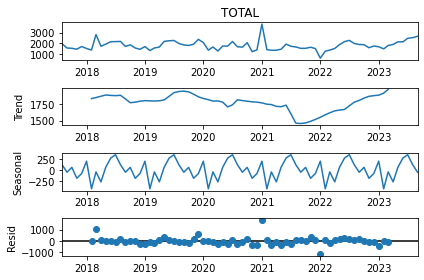

In [35]:
result = seasonal_decompose(bomberos_total.TOTAL)
result.plot();

### Separación de los datos en train y test

In [36]:
df = bomberos_total

In [37]:
size = int(len(df)*0.8)
train, test = df.iloc[:size], df.iloc[size:]

### Test de Dickey-Fuller

In [38]:
sts.adfuller(df.TOTAL)

(-6.392988422943006,
 2.0836722009257098e-08,
 0,
 73,
 {'1%': -3.5232835753964475,
  '5%': -2.902030597326081,
  '10%': -2.5883710883843123},
 918.2391857010462)

El p-valor del test de Dickey-Fuller es menor a 0.05, por tanto se rechaza la hipótesis nula, lo que sugiere que la serie es estacionaria, aunque los intervalos de confianza no sean los óptimos.

### Estudio de correlaciones

#### ACF

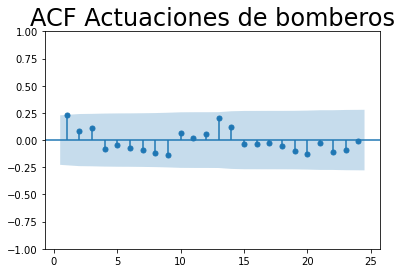

In [39]:
sgt.plot_acf(df.TOTAL, lags = 24, zero = False)
plt.title("ACF Actuaciones de bomberos", size = 24)
plt.show()

La autocorrelación simple sobre 24 meses previos no muestran una influencia significativa de los meses anteriores. Como mucho se puede destacar el mes anterior. Pero cabe mencionar que tal como se ha comprobado en los gráficos no siempre tiene porque ser así, vease enero de 2021.

#### PACF

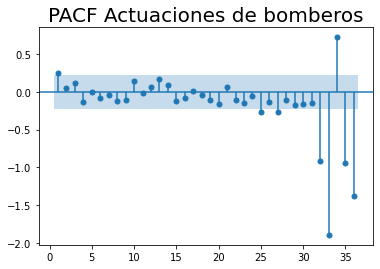

In [40]:
sgt.plot_pacf(df.TOTAL, lags = 36, zero = False, method = ('ols'))
plt.title("PACF Actuaciones de bomberos", size = 20)
plt.autoscale()
plt.show()

La autocorrelación parcial muestra cierta correlación directa de cada 34 meses, el análisis se realiza en el documento pdf.

### Prediccion Holt-Winters, técnicas de suvizado

A continuación se presentan varios modelos. Aquellos que se encuentran comentados no han obtenido buenos resultados, pero se mantienen para dejar constancia de las pruebas que se han realizado.

In [41]:
span = 12
alpha = 2/(span+1)

In [42]:
# model_1 = SimpleExpSmoothing(train.TOTAL).fit()
# autoSES=SimpleExpSmoothing(train.TOTAL).fit()
# print("SES Calculated Smooted: " + str(autoSES.params['smoothing_level']))
# autoSES_12 = SimpleExpSmoothing(train.TOTAL).fit(smoothing_level=alpha,optimized=False)
# model_1_12 = autoSES_12
# model_1_values = autoSES_12.fittedvalues.shift(-1)

In [43]:
# model_2_add = ExponentialSmoothing(train.TOTAL,trend='add').fit()
# model_2_mul = ExponentialSmoothing(train.TOTAL,trend='mul').fit()

In [44]:
model_3_add_add = ExponentialSmoothing(train.TOTAL,trend='add',seasonal='add',seasonal_periods=12).fit()
model_3_add_mul = ExponentialSmoothing(train.TOTAL,trend='add',seasonal='mul',seasonal_periods=12).fit()
model_3_mul_add = ExponentialSmoothing(train.TOTAL,trend='mul',seasonal='add',seasonal_periods=12).fit()
model_3_mul_mul = ExponentialSmoothing(train.TOTAL,trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [45]:
# forecast_1_12= model_1_12.forecast(14)
# forecast_add_2 = model_2_add.forecast(14)
# forecast_mul_2= model_2_mul.forecast(14)
forecast_add_add_3 = model_3_add_add.forecast(14)
forecast_add_mul_3= model_3_add_mul.forecast(14)
forecast_mul_add_3= model_3_mul_add.forecast(14)
forecast_mul_mul_3= model_3_mul_mul.forecast(14)

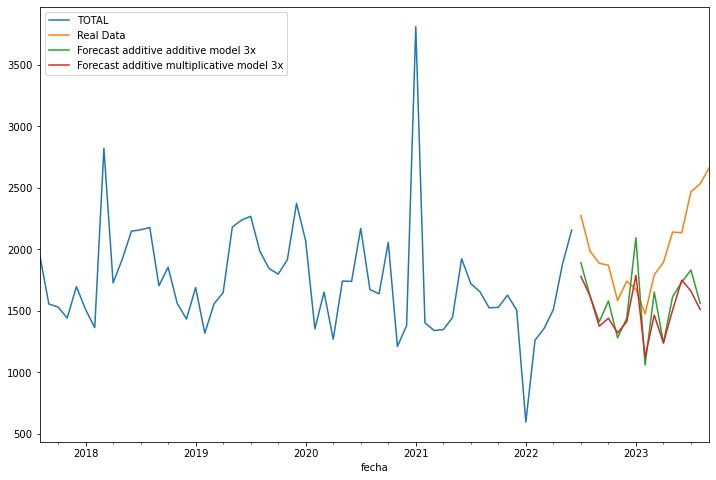

In [46]:
train.TOTAL.plot(figsize=(12,8))
test.TOTAL.plot(label='Real Data');
# model_1_values.plot(label='Trend model 1x (12)');
#forecast_1.plot(label='Forecast model 1x');
# forecast_1_12.plot(label='Forecast model 1x (12)');
# forecast_add_2.plot(label='Forecast additive model 2x');
# forecast_mul_2.plot(label='Forecast multiplicative model 2x');
forecast_add_add_3.plot(label='Forecast additive additive model 3x');
forecast_add_mul_3.plot(label='Forecast additive multiplicative model 3x');
# forecast_mul_add_3.plot(label='Forecast multiplicative additive model 3x');
# forecast_mul_mul_3.plot(label='Forecast multiplicative multiplicative model 3x');
plt.legend(loc='upper left')

Las predicción obtenida mediante la técnica de Holt-Winters no es una mala primera aproximación, pues es capaz de entender la tendencia que deberían de seguir los datos. Probaremos con los modelos ARMA y ARIMA, además de contemplar las posibles variables exógenas.

## AR

In [47]:
model_ar = ARIMA(train.TOTAL, order=(12,0,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  TOTAL   No. Observations:                   59
Model:                ARIMA(12, 0, 0)   Log Likelihood                -441.330
Date:                Sun, 21 Jan 2024   AIC                            910.660
Time:                        19:39:54   BIC                            939.746
Sample:                    08-01-2017   HQIC                           922.014
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1755.0733     70.988     24.724      0.000    1615.940    1894.207
ar.L1          0.1219      0.160      0.760      0.447      -0.193       0.436
ar.L2         -0.0513      0.189     -0.271      0.786      -0.422       0.319
ar.L3          0.1048      0.176      0.596      0.551      -0.240       0.449
ar.L4         -0.1226      0.277     -0.442      0.658      -0.666       0.421
ar.L5          0.0145      0.225      0.065      0.949      -0.426       0.455
ar.L6          0.0019      0.324      0.006      0.995      -0.632       0.636
ar.L7         -0.0262      0.222     -0.118      0.906      -0.462       0.410
ar.L8         -0.1179      0.416     -0.284      0.777      -0.933       0.697
ar.L9         -0.1854      0.297     -0.624      0.533      -0.768       0.397
ar.L10         0.0724      0.189      0.383      0.702      -0.298       0.443
ar.L11        -0.0841      0.227     -0.370      0.711      -0.529       0.361
ar.L12        -0.0066      0.143     -0.046      0.964      -0.288       0.275
sigma2      1.804e+05   3.69e+04      4.893      0.000    1.08e+05    2.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               108.66
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.56   Skew:                             1.35
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

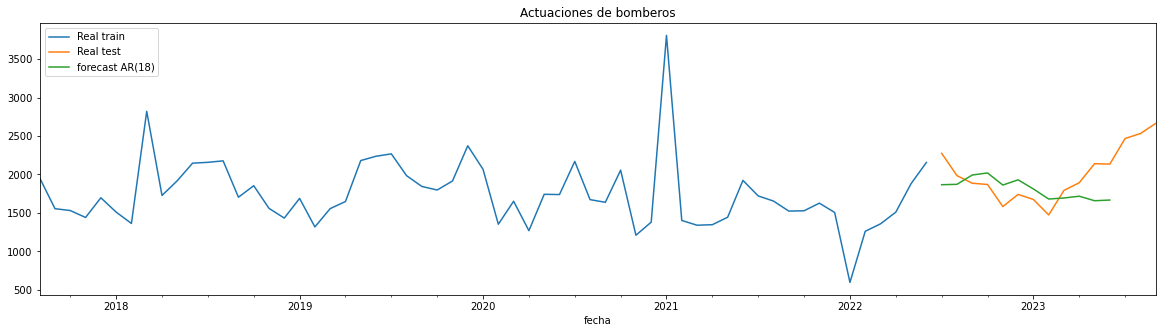

In [48]:
forecast_AR = results_ar.forecast(steps=12)

train.TOTAL.plot(label='Real train')
test.TOTAL.plot(label='Real test')
forecast_AR.plot(figsize=(20,5), title = "Actuaciones de bomberos",label='forecast AR(18)')
plt.legend(loc="upper left")
plt.show()

También añadiremos algunos candidatos que al hacer la **PACF** se nos muestra que tienen cierta relevancia a la hora de predecir

In [49]:
from sklearn.metrics import mean_squared_error

testGeneral = [i for i in range(25)]
testGeneral.append(33)
testGeneral.append(34)

ModelArima=dict()
for x in testGeneral:
  model_ar = ARIMA(train.TOTAL, order=(x,0,0))
  results_ar = model_ar.fit()
  results_arfore = results_ar.forecast(steps=len(test.TOTAL))
  ModelArima["AR("+str(x)+")"] = results_arfore

  error = mean_squared_error(test.TOTAL, results_arfore)
  print("AR("+str(x)+") \t LLF:"+str(results_ar.llf)+"     \t AIC:"+str(results_ar.aic)+"      \t BIC:"+str(results_ar.bic)+"     \t ERROR:"+str(error))

AR(0) 	 LLF:-443.93251154159833     	 AIC:891.8650230831967      	 BIC:896.0200979710081     	 ERROR:187005.9958058031
AR(1) 	 LLF:-443.5736434432068     	 AIC:893.1472868864136      	 BIC:899.3798992181307     	 ERROR:183493.26205524334
AR(2) 	 LLF:-443.55800353731155     	 AIC:895.1160070746231      	 BIC:903.426156850246     	 ERROR:184395.63301438076
AR(3) 	 LLF:-443.3435047587352     	 AIC:896.6870095174704      	 BIC:907.074696736999     	 ERROR:184879.3857315601
AR(4) 	 LLF:-442.94772552167984     	 AIC:897.8954510433597      	 BIC:910.360675706794     	 ERROR:181624.05637143913
AR(5) 	 LLF:-442.89419918980843     	 AIC:899.7883983796169      	 BIC:914.331160486957     	 ERROR:182395.2295190408
AR(6) 	 LLF:-442.8915468466681     	 AIC:901.7830936933362      	 BIC:918.403393244582     	 ERROR:181199.72532628715
AR(7) 	 LLF:-442.8912650053337     	 AIC:903.7825300106674      	 BIC:922.4803670058188     	 ERROR:180930.15581945845
AR(8) 	 LLF:-442.39621569763995     	 AIC:904.792431

No hay ningun valor especialmente bueno. Visualizamos alguno para observar las predicciones

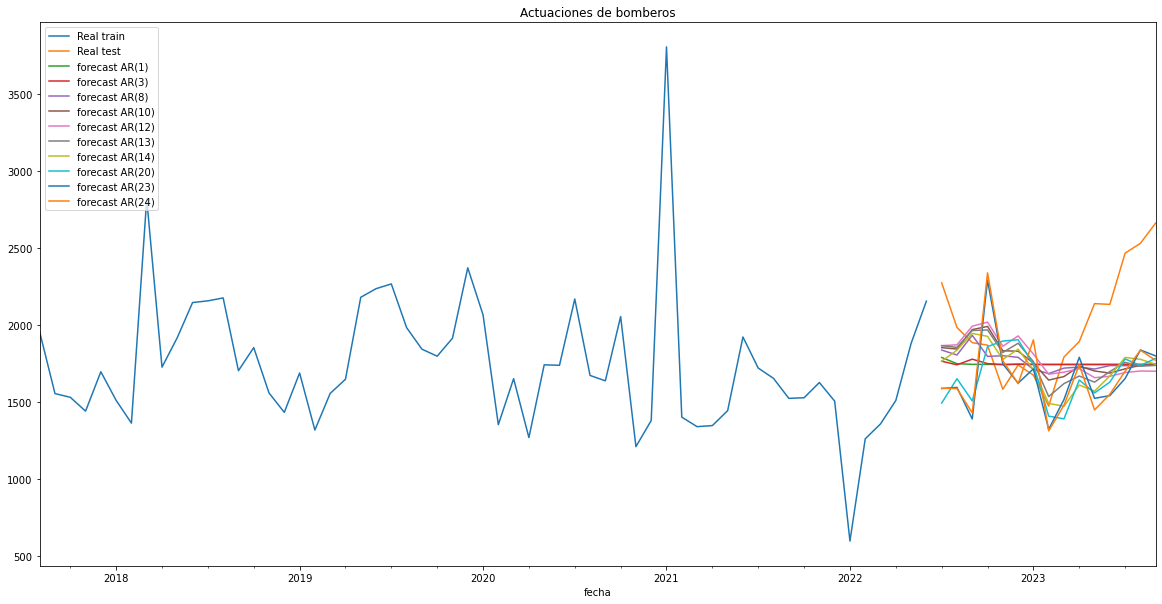

In [50]:
orden = [1, 3, 8, 10, 12, 13, 14, 20, 23, 24]

train.TOTAL.plot(figsize=(20,10), title = "Actuaciones de bomberos", label='Real train')
test.TOTAL.plot(label='Real test')

for x in orden:
   ModelArima["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")

plt.legend(loc="upper left")
plt.show()

Mostramos algún resultado particular que obtenemos con AR.

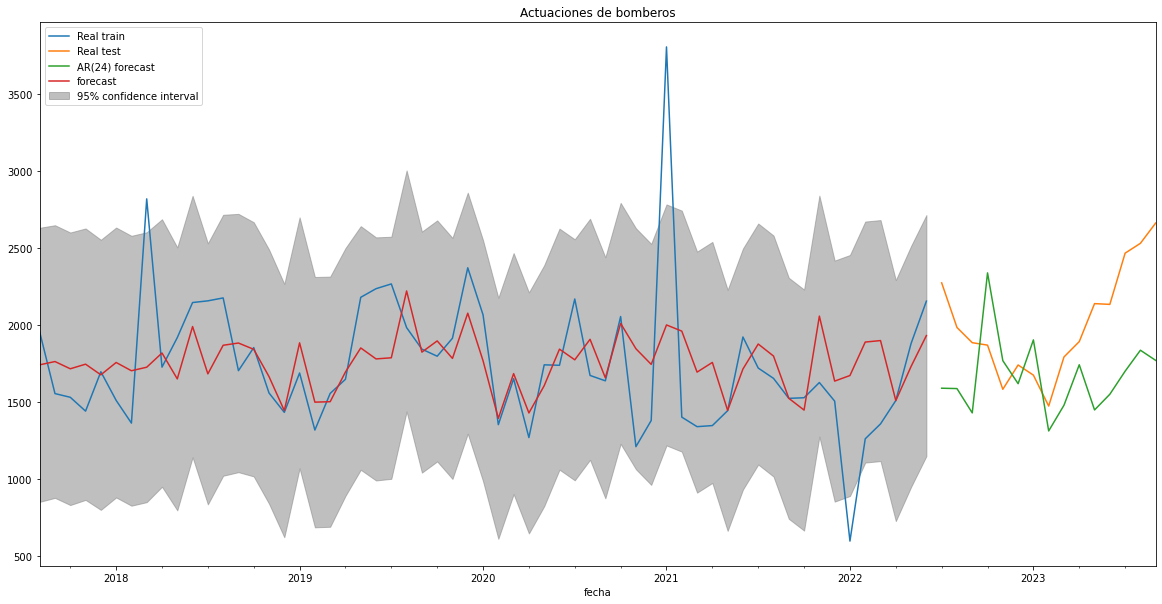

In [51]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos", label='Real test')

# model_ar = ARIMA(train.TOTAL, order=(14,0,0))
model_ar = ARIMA(train.TOTAL, order=(24,0,0))
results_ar = model_ar.fit()
results_arfore = results_ar.forecast(steps=15)

ax = results_arfore.plot(ax=ax, label='AR(24) forecast')
plot_predict(results_ar, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

## MA

In [52]:
model__ma = ARIMA(train.TOTAL, order=(0,0,1))
resultst_ma = model__ma.fit()
resultst_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  TOTAL   No. Observations:                   59
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -443.546
Date:                Sun, 21 Jan 2024   AIC                            893.093
Time:                        19:40:26   BIC                            899.325
Sample:                    08-01-2017   HQIC                           895.526
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1744.5654     79.692     21.891      0.000    1588.372    1900.759
ma.L1          0.1200      0.132      0.912      0.362      -0.138       0.378
sigma2      1.982e+05    2.2e+04      9.011      0.000    1.55e+05    2.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               154.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                             1.75
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

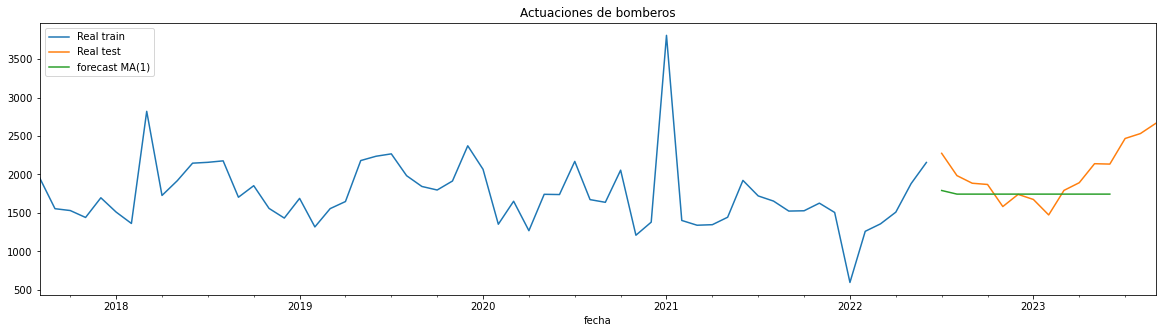

In [53]:
forecast_MA = resultst_ma.forecast(steps=12)
train.TOTAL.plot(label='Real train')
test.TOTAL.plot(label='Real test')
forecast_MA.plot(figsize=(20,5), title = "Actuaciones de bomberos",label='forecast MA(1)')
plt.legend(loc="upper left")
plt.show()

In [54]:
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

testGeneral = [i for i in range(25)]
testGeneral.append(33)
testGeneral.append(34)
testGeneral.append(35)

from sklearn.metrics import mean_squared_error

ModelArima=dict()
results_maprey=None
for x in testGeneral:
  model_ma = ARIMA(train.TOTAL, order=(0,0,x))
  results_ma = model_ma.fit()
  results_mafore = results_ma.forecast(steps=len(test.TOTAL))
  ModelArima["MA("+str(x)+")"] = results_mafore

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma))

  results_maprey=results_ma

  print("MA("+str(x)+") \t LLF:"+str(results_ma.llf)+"     \t AIC:"+str(results_ma.aic)+"      \t BIC:"+str(results_ma.bic)+"     \t LLR test p-value:"+str(error))

MA(0) 	 LLF:-443.93251154159833     	 AIC:891.8650230831967      	 BIC:896.0200979710081     	 LLR test p-value:None
MA(1) 	 LLF:-443.54630353011436     	 AIC:893.0926070602287      	 BIC:899.3252193919459     	 LLR test p-value:0.379
MA(2) 	 LLF:-443.4818204937663     	 AIC:894.9636409875326      	 BIC:903.2737907631555     	 LLR test p-value:0.72
MA(3) 	 LLF:-443.18729595312544     	 AIC:896.3745919062509      	 BIC:906.7622791257795     	 LLR test p-value:0.443
MA(4) 	 LLF:-442.8930478979443     	 AIC:897.7860957958886      	 BIC:910.251320459323     	 LLR test p-value:0.443
MA(5) 	 LLF:-442.8536612933087     	 AIC:899.7073225866174      	 BIC:914.2500846939574     	 LLR test p-value:0.779
MA(6) 	 LLF:-442.785905956179     	 AIC:901.571811912358      	 BIC:918.1921114636039     	 LLR test p-value:0.713
MA(7) 	 LLF:-442.7115887929797     	 AIC:903.4231775859594      	 BIC:922.1210145811108     	 LLR test p-value:0.7
MA(8) 	 LLF:-442.49795098229885     	 AIC:904.9959019645977      	 B

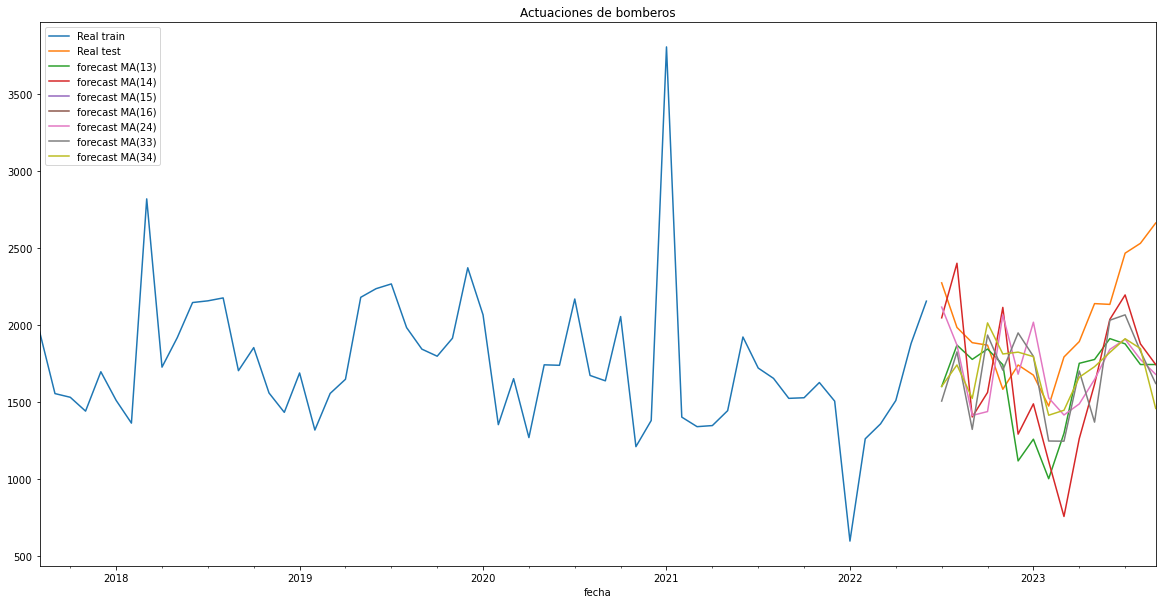

In [55]:
candidatos = [13, 14, 15, 16, 24, 33, 34]

train.TOTAL.plot(figsize=(20,10), title = "Actuaciones de bomberos", label='Real train')
test.TOTAL.plot(label='Real test')
for x in candidatos:
   ModelArima["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error

ModelArima=dict()
results_maprey=None

for x in candidatos:
  model_ma = ARIMA(train.TOTAL, order=(0,0,x))
  results_ma = model_ma.fit()
  results_mafore = results_ma.forecast(steps=len(test.TOTAL))
  ModelArima["MA("+str(x)+")"] = results_mafore

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma))

  results_maprey=results_ma

  print("MA("+str(x)+") \t LLF:"+str(results_ma.llf)+"     \t AIC:"+str(results_ma.aic)+"      \t BIC:"+str(results_ma.bic)+"     \t LLR test p-value:"+str(error))

MA(13) 	 LLF:-442.6751992009988     	 AIC:915.3503984019976      	 BIC:946.5134600605834     	 LLR test p-value:None
MA(14) 	 LLF:-516.7149048342002     	 AIC:1065.4298096684004      	 BIC:1098.670408770892     	 LLR test p-value:1.0
MA(15) 	 LLF:nan     	 AIC:nan      	 BIC:nan     	 LLR test p-value:nan
MA(16) 	 LLF:nan     	 AIC:nan      	 BIC:nan     	 LLR test p-value:nan
MA(24) 	 LLF:-437.4810919574441     	 AIC:926.9621839148882      	 BIC:980.978157456437     	 LLR test p-value:nan
MA(33) 	 LLF:-434.4858165856372     	 AIC:938.9716331712744      	 BIC:1011.6854437079746     	 LLR test p-value:0.014
MA(34) 	 LLF:-433.738474207941     	 AIC:939.476948415882      	 BIC:1014.2682963964879     	 LLR test p-value:0.221


Mostramos el mejor resultado que hemos obtenido con MA.

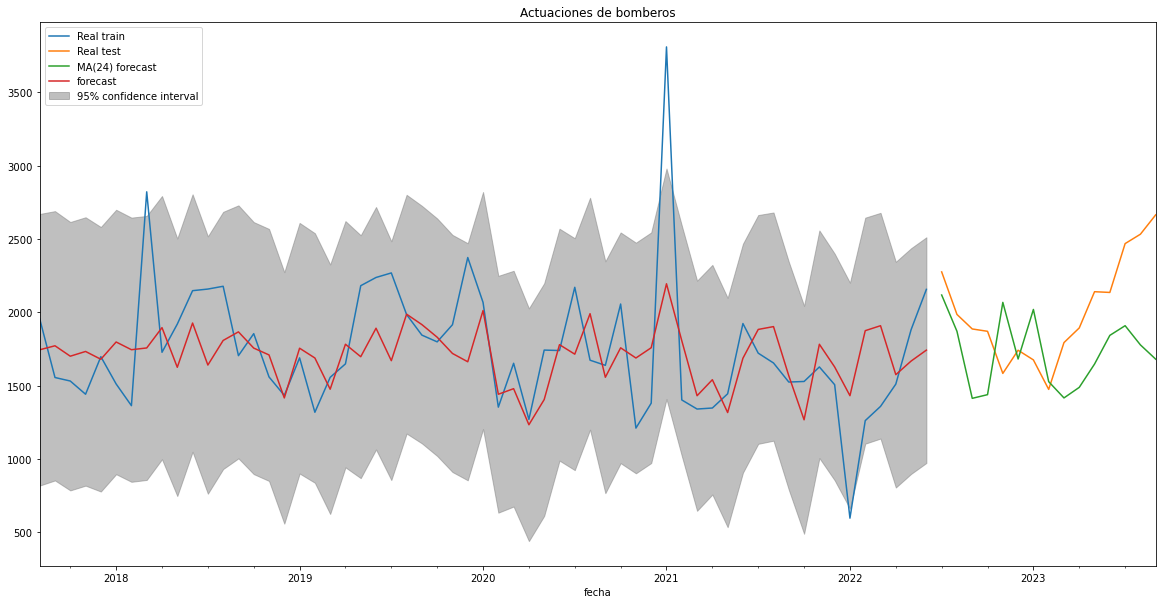

In [57]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos", label='Real test')
model_ma = ARIMA(train.TOTAL, order=(0,0,24))
results_ma = model_ma.fit()
results_mafore = results_ma.forecast(steps=15)
ax = results_mafore.plot(ax=ax,label='MA(24) forecast')
plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

### ARMA

Dado a que la serie sugiere ser estacional, probamos ARMA con los valores de _p_ y _q_ aceptables obtenidos en los modelos AR y MA.

In [58]:
model_arma_1_1 = ARIMA(train.TOTAL, order=(1,0,1))
results_arma_1_1 = model_arma_1_1.fit()
sts.adfuller(results_arma_1_1.resid)

(-7.430807125772382,
 6.368292066881696e-11,
 0,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 711.8862609908513)

In [59]:
model_arma_12_34 = ARIMA(train.TOTAL, order=(33,0,24))
results_arma_12_34 = model_arma_12_34.fit()
sts.adfuller(results_arma_12_34.resid)

(-7.57071449035368,
 2.8462207460890157e-11,
 0,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 676.0309504022666)

In [60]:
LLR_test(results_arma_12_34, results_arma_1_1)

1.0

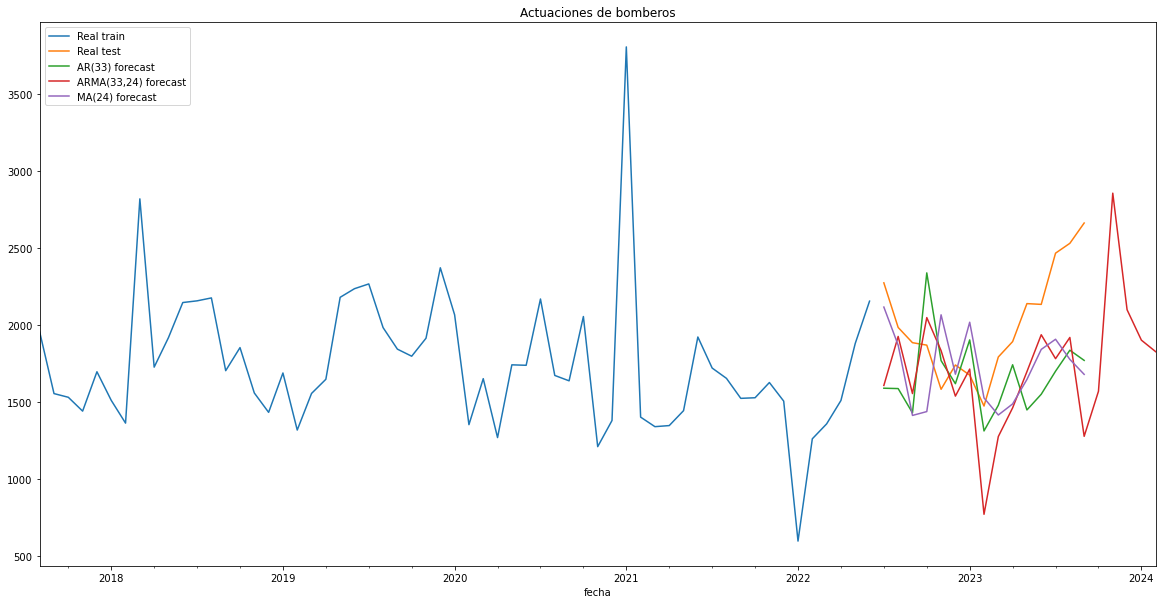

In [61]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos", label='Real test')
model_arma = ARIMA(
    train.TOTAL, order=(33, 0, 24))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=20)
ax = results_arfore.plot(ax=ax, label='AR(33) forecast')
ax = results_armafore.plot(ax=ax,label='ARMA(33,24) forecast')
ax = results_mafore.plot(ax=ax,label='MA(24) forecast')
plt.legend(loc="upper left")
plt.show()

A pesar de resultar un poco lioso el gráfico, podemos ver que las predicciones distan de ser buenas. A pesar de ello, la predicción obtenida usando MA(24), es relativamente mejor que las demás desde nuestro punto de vista, aunque parece que está un poco desplazada con respecto a la real.

### ARIMA

In [62]:
model_arima = ARIMA(train.TOTAL, order=(34,2,24))
results_arima = model_arima.fit()
sts.adfuller(results_arima.resid)

(-9.95584749035427,
 2.4455124478965292e-17,
 0,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 710.3491928032738)

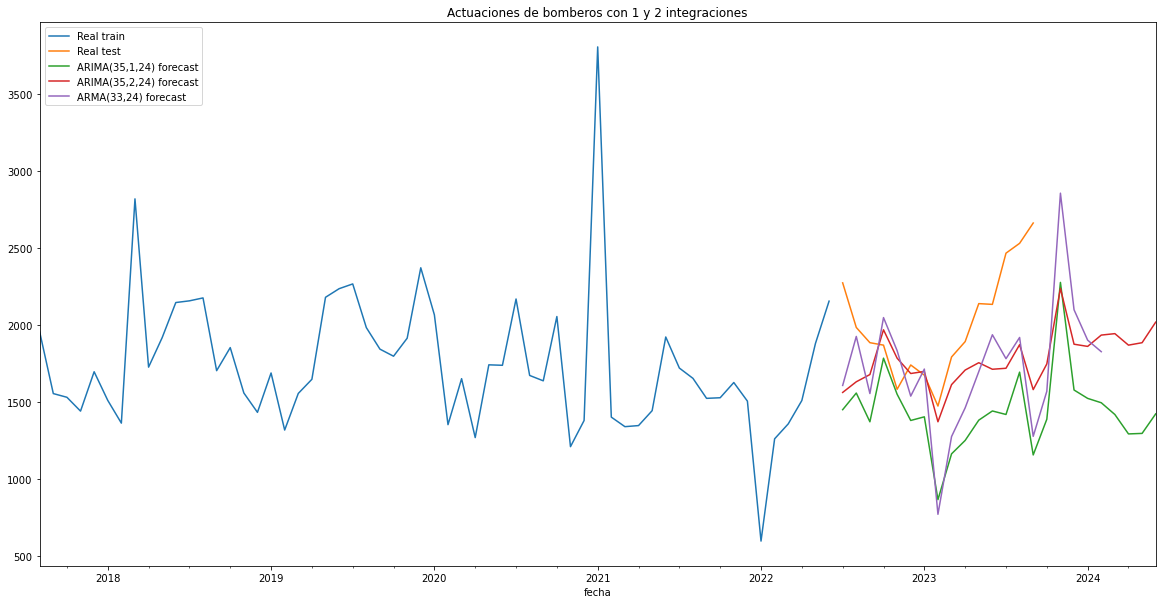

In [63]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos con 1 y 2 integraciones", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos con 1 y 2 integraciones", label='Real test')

model_arima_1_ints = ARIMA(train.TOTAL, order=(34,1,24))
results_arima_1_int = model_arima_1_ints.fit()
results_arimafore_1_int = results_arima_1_int.forecast(steps=24)

model_arima_2_ints = ARIMA(train.TOTAL, order=(34,2,24))
results_arima_2_int = model_arima_2_ints.fit()
results_arimafore_2_int = results_arima_2_int.forecast(steps=24)

model_arma = ARIMA(
    train.TOTAL, order=(33, 0, 24))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=20)


ax = results_arimafore_1_int.plot(ax=ax,label='ARIMA(35,1,24) forecast')
ax = results_arimafore_2_int.plot(ax=ax,label='ARIMA(35,2,24) forecast')
ax = results_armafore.plot(ax=ax,label='ARMA(33,24) forecast')

plt.legend(loc="upper left")
plt.show()

Los resultados continúan lejos de los valores reales, aunque vemos como un modelo ARMA sí empieza a aproximarse al objetivo. Además, el modelo ARIMA con dos integraciones también consigue reproducir el principio de los valores de test aunque luego no siga la tendencia ascendente de los datos reales.

### Pruebas LSTM

In [64]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

size = int(len(df)*0.8)
train, test = df.iloc[:size], df.iloc[size:]

data_train = train.drop(columns=['tendencia'])
data_test = test.drop(columns=['tendencia'])

scaler = MinMaxScaler()

scaler.fit(data_train)

scaled_train = scaler.transform(data_train)
scaled_test = scaler.transform(data_test)

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [65]:
generator[0]

(array([[[0.42296919],
         [0.29847495],
         [0.29100529],
         [0.26299409],
         [0.3426704 ],
         [0.28478058],
         [0.23871771],
         [0.69249922],
         [0.35200747],
         [0.41176471],
         [0.48272642],
         [0.48615002]]]),
 array([[0.49206349]]))

In [66]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 12, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 12, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [68]:
model.fit_generator(generator,epochs=15)

Epoch 1/15
47/47 [==============================] - 13s 136ms/step - loss: 0.1361
Epoch 2/15
47/47 [==============================] - 6s 124ms/step - loss: 0.1323
Epoch 3/15
47/47 [==============================] - 6s 122ms/step - loss: 0.1078
Epoch 4/15
47/47 [==============================] - 6s 134ms/step - loss: 0.1175
Epoch 5/15
47/47 [==============================] - 6s 131ms/step - loss: 0.1033
Epoch 6/15
47/47 [==============================] - 6s 128ms/step - loss: 0.1016
Epoch 7/15
47/47 [==============================] - 6s 136ms/step - loss: 0.1089
Epoch 8/15
47/47 [==============================] - 6s 131ms/step - loss: 0.1043
Epoch 9/15
47/47 [==============================] - 6s 132ms/step - loss: 0.1062
Epoch 10/15
47/47 [==============================] - 6s 131ms/step - loss: 0.0977
Epoch 11/15
47/47 [==============================] - 6s 126ms/step - loss: 0.1044
Epoch 12/15
47/47 [==============================] - 7s 141ms/step - loss: 0.1094
Epoch 13/15
47/47 [=====

1/1 [==============================] - 0s 47ms/step


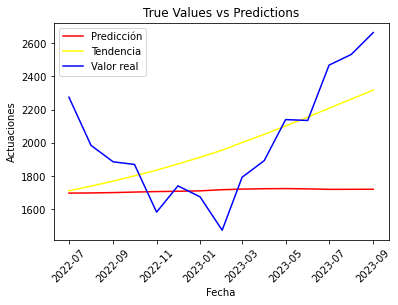

In [69]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions


plt.plot(test['Predictions'], label='Predicción', color='red')
plt.plot(test['tendencia'], label='Tendencia', color='yellow')
plt.plot(test['TOTAL'], label='Valor real', color='blue')


plt.xlabel('Fecha')
plt.ylabel('Actuaciones')
plt.xticks(rotation=45)
plt.title('True Values vs Predictions')
plt.legend()

Viendo los pocos datos que tenemos, tanto de train como de test, es normal que un modelo de deep learning no consiga buenos resultados. Por ello, continuaremos explorando otras alternativas.

Para poder usar SARIMAX, necesitamos obtener las predicciones de las actuaciones de los otros cuerpos. Tras ello, usaremos los valores de estas series para ayudarnos a predecir la serie de las actuaciones de los bomberos. Los dos siguientes apartados realizan el mismo proceso que el anterior pero aplicado a los datos del SAMUR y de la policía. Aunque hemos eliminado la parte de LSTM por la falta de datos.


# Estudio de los datos del SAMUR

In [70]:
samur_total

TOTAL
fecha              
2017-01-01  10368.0
2017-02-01  10100.0
2017-03-01  11455.0
2017-04-01  11226.0
2017-05-01  12582.0
...             ...
2023-05-01  13668.0
2023-06-01  13518.0
2023-07-01  13698.0
2023-08-01  10954.0
2023-09-01  12544.0

[81 rows x 1 columns]

In [71]:
fig = px.bar(samur_total, y='TOTAL', title='Actuaciones del Samur')
fig.show()

In [72]:
fig = px.line(samur_total, y='TOTAL', title='Actuaciones del Samur')
fig.show()

In [73]:
circular_samur, tendencia_samur = hpfilter(samur_total['TOTAL'], lamb=1600)
samur_total['tendencia'] = tendencia_samur

fig = px.line(samur_total, x=samur_total.index, y=['TOTAL', 'tendencia'], title='tendencia')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()

In [74]:
df_samur = samur_total.copy()

In [75]:
df_samur.head()

TOTAL     tendencia
fecha                            
2017-01-01  10368.0  11014.081072
2017-02-01  10100.0  11083.781798
2017-03-01  11455.0  11153.078722
2017-04-01  11226.0  11220.953182
2017-05-01  12582.0  11286.575213

## Test de Dickey-Fuller

In [76]:
sts.adfuller(df_samur.TOTAL)

(-2.4332475813836454,
 0.132571525976031,
 12,
 68,
 {'1%': -3.530398990560757,
  '5%': -2.9050874099328317,
  '10%': -2.5900010121107266},
 1161.554581897976)

Como el p-valor es mayor a 0.05 no se puede rechazar la hipótesis nula de que la serie del SAMUR no es estacionaria. Calculamos los retornos para saber el cambio porcentual de los meses a lo largo del tiempo.

In [77]:
df_samur['returns'] = df_samur.TOTAL.pct_change(1)*100

In [78]:
sts.adfuller(df_samur['returns'][1:])

(-2.7680566076077833,
 0.06298351085136873,
 12,
 67,
 {'1%': -3.5319549603840894,
  '5%': -2.905755128523123,
  '10%': -2.5903569458676765},
 524.090831541638)

El p-valor sigue sin ser menor a 0.05, volvemos a iterar

In [79]:
df_samur['returns_returns'] = df_samur.returns.pct_change(1)*100

In [80]:
sts.adfuller(df_samur['returns_returns'][2:])

(-8.892153843580992,
 1.2341833695872612e-14,
 0,
 78,
 {'1%': -3.517113604831504,
  '5%': -2.8993754262546574,
  '10%': -2.5869547797501644},
 1115.6804920014872)

## Estudios de Autocorrelación

#### ACF

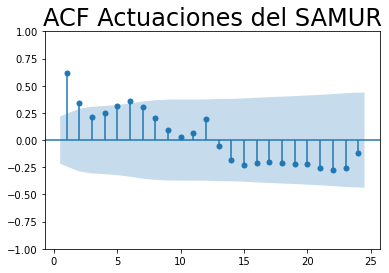

In [81]:
sgt.plot_acf(df_samur.TOTAL, lags = 24, zero = False)
plt.title("ACF Actuaciones del SAMUR", size = 24)
plt.show()

#### PACF

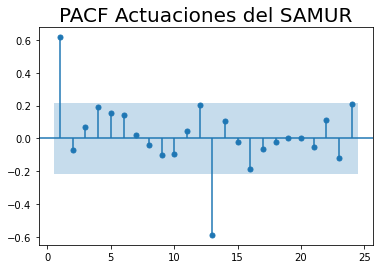

In [82]:
sgt.plot_pacf(df_samur.TOTAL, lags = 24, zero = False, method = ('ols'))
plt.title("PACF Actuaciones del SAMUR", size = 20)
plt.autoscale()
plt.show()

#### ACF con retornos

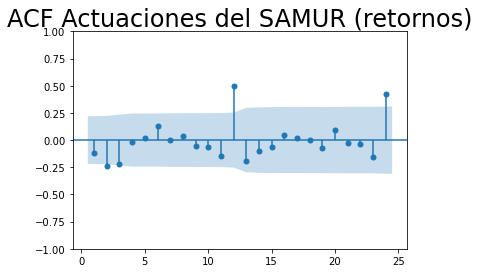

In [83]:
sgt.plot_acf(df_samur['returns'][1:], lags = 24, zero = False)
plt.title("ACF Actuaciones del SAMUR (retornos)", size = 24)
plt.show()

#### PACF con retornos

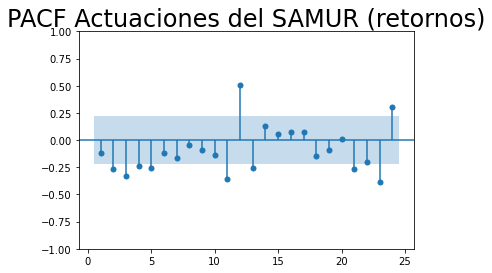

In [84]:
sgt.plot_pacf(df_samur['returns'][1:], lags = 24, zero = False)
plt.title("PACF Actuaciones del SAMUR (retornos)", size = 24)
plt.show()

## AR

In [85]:
size = int(len(df_samur)*0.8)
train_samur, test_samur = df_samur.iloc[:size], df_samur.iloc[size:]

In [86]:
rango = [i for i in range(0,25)]

In [87]:
ModelArima_samur=dict()

for x in rango:
  model_ar_samur = ARIMA(train_samur.returns_returns[2:], order=(x,0,0))
  results_ar_samur = model_ar_samur.fit()
  results_arfore_samur = results_ar_samur.forecast(steps=len(test_samur.returns))
  ModelArima_samur["AR("+str(x)+")"] = results_arfore_samur

  error = mean_squared_error(test_samur.returns, results_arfore_samur)
  print("AR("+str(x)+") \t LLF:"+str(results_ar_samur.llf)+"     \t AIC:"+str(results_ar_samur.aic)+"      \t BIC:"+str(results_ar_samur.bic)+"     \t ERROR:"+str(error))

AR(0) 	 LLF:-490.0714616205187     	 AIC:984.1429232410374      	 BIC:988.3971920111276     	 ERROR:12255.224907881595
AR(1) 	 LLF:-489.9315604881326     	 AIC:985.8631209762652      	 BIC:992.2445241314006     	 ERROR:12296.772666987112
AR(2) 	 LLF:-489.4793119846494     	 AIC:986.9586239692989      	 BIC:995.4671615094792     	 ERROR:11674.070696583032
AR(3) 	 LLF:-489.401298720093     	 AIC:988.802597440186      	 BIC:999.4382693654114     	 ERROR:13804.700199207691
AR(4) 	 LLF:-489.4164533327419     	 AIC:990.8329066654838      	 BIC:1003.5957129757544     	 ERROR:13666.304906671316
AR(5) 	 LLF:-489.10426984176905     	 AIC:992.2085396835381      	 BIC:1007.0984803788538     	 ERROR:11119.217409007182
AR(6) 	 LLF:-488.8380953478993     	 AIC:993.6761906957986      	 BIC:1010.6932657761594     	 ERROR:8425.081327977305
AR(7) 	 LLF:-487.3843124745137     	 AIC:992.7686249490274      	 BIC:1011.9128344144333     	 ERROR:15638.631665881967
AR(8) 	 LLF:-487.3489797395919     	 AIC:994.6

Probamos los valores con:
- LLF con valores altos
- AIC con valores bajos, lo que pueden indicar que son buenos predictores
- BIC bajos
- Error bajos

Nos centraremos principalmente a que el error sea bajo, pero incluiremos algunos otros valores de prueba con ciertos LLF, AIC o BIC peculiares.

In [88]:
valores = [1, 2, 3, 4, 12, 17]

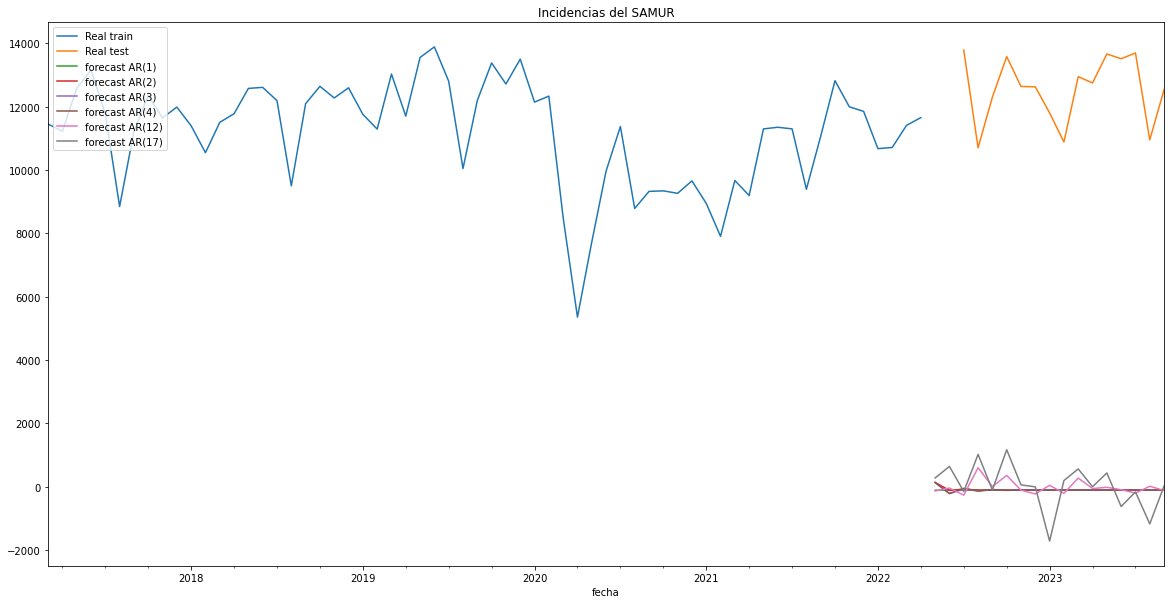

In [89]:
train_samur.TOTAL[2:].plot(figsize=(20,10), title = "Incidencias del SAMUR", label='Real train')
test_samur.TOTAL[2:].plot(label='Real test')
for x in valores:
   ModelArima_samur["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

Mostramos los mejores resultados que hemos obtenido.

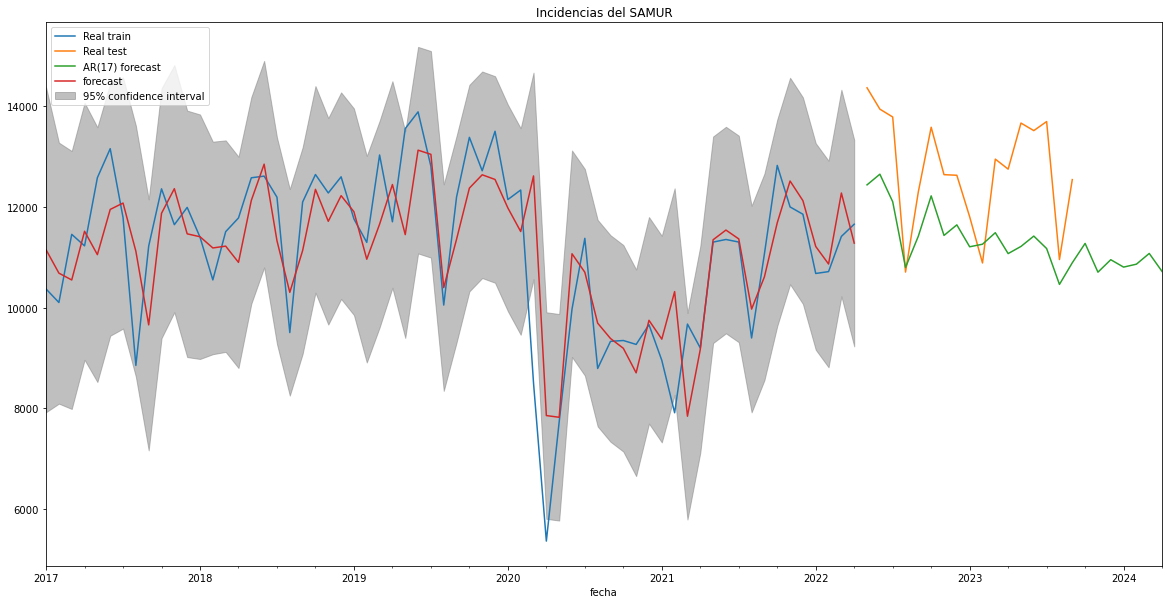

In [90]:
fig, ax = plt.subplots()
ax = train_samur.TOTAL.plot(ax=ax,figsize=(20,10), title = "Incidencias del SAMUR", label='Real train')
ax = test_samur.TOTAL.plot(ax=ax,figsize=(20,10), title = "Incidencias del SAMUR", label='Real test')
model_ar_samur = ARIMA(train_samur.TOTAL, order=(17,0,0))
results_ar_samur = model_ar_samur.fit()
results_arfore_samur = results_ar_samur.forecast(steps=24)
ax = results_arfore_samur.plot(ax=ax, label='AR(17) forecast')
plot_predict(results_ar_samur, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

## MA

In [91]:
ModelArima_samur=dict()
results_maprey=None

def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

for x in rango:
  model_ma_samur = ARIMA(train_samur.returns_returns[2:], order=(0,0,x))
  results_ma_samur = model_ma_samur.fit()
  results_mafore_samur = results_ma_samur.forecast(steps=len(test_samur.returns))
  ModelArima_samur["MA("+str(x)+")"] = results_mafore_samur

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma_samur))

  results_maprey=results_ma_samur

  print("MA("+str(x)+") \t LLF:"+str(results_ma_samur.llf)+"     \t AIC:"+str(results_ma_samur.aic)+"      \t BIC:"+str(results_ma_samur.bic)+"     \t LLR test p-value:"+str(error))

MA(0) 	 LLF:-490.0714616205187     	 AIC:984.1429232410374      	 BIC:988.3971920111276     	 LLR test p-value:None
MA(1) 	 LLF:-489.9567034998284     	 AIC:985.9134069996568      	 BIC:992.294810154792     	 LLR test p-value:0.632
MA(2) 	 LLF:-489.5364928212466     	 AIC:987.0729856424932      	 BIC:995.5815231826735     	 LLR test p-value:0.359
MA(3) 	 LLF:-489.3795365116021     	 AIC:988.7590730232042      	 BIC:999.3947449484297     	 LLR test p-value:0.575
MA(4) 	 LLF:-489.3054649499191     	 AIC:990.6109298998382      	 BIC:1003.3737362101087     	 LLR test p-value:0.7
MA(5) 	 LLF:-489.2232800011251     	 AIC:992.4465600022502      	 BIC:1007.3365006975658     	 LLR test p-value:0.685
MA(6) 	 LLF:-488.84953779506117     	 AIC:993.6990755901223      	 BIC:1010.7161506704831     	 LLR test p-value:0.387
MA(7) 	 LLF:-487.52453302921504     	 AIC:993.0490660584301      	 BIC:1012.1932755238358     	 LLR test p-value:0.104
MA(8) 	 LLF:-487.5176116369242     	 AIC:995.0352232738484    

Escogemos valores cuyo p-valor sea menor a 0.05 o cercanos

In [92]:
valores_ma_samur = [10, 12, 15, 24]

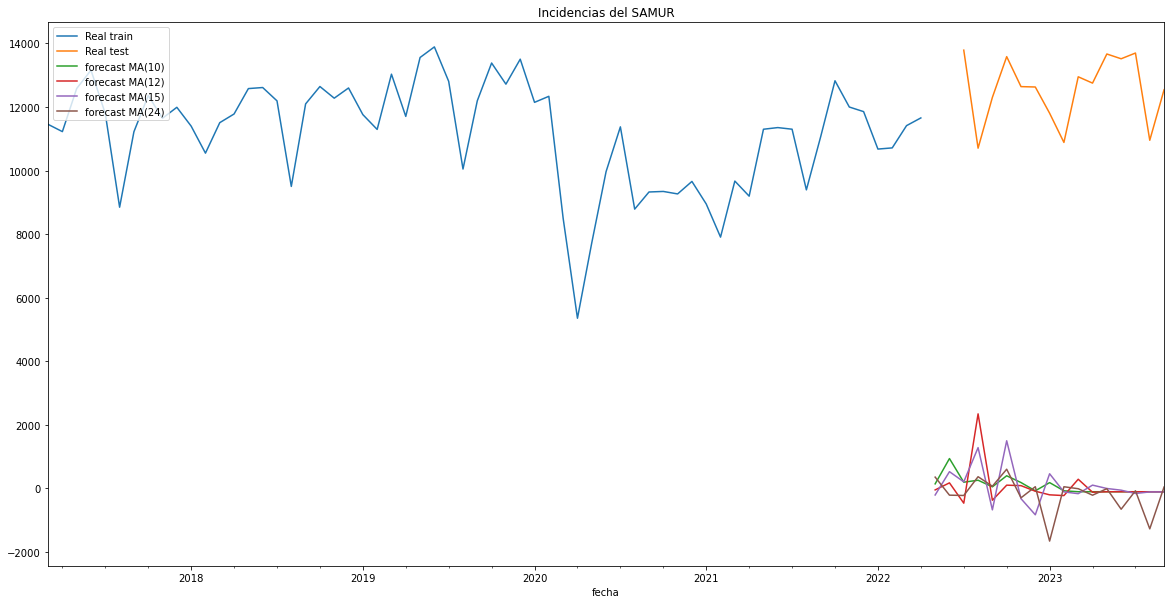

In [93]:
train_samur.TOTAL[2:].plot(figsize=(20,10), title = "Incidencias del SAMUR", label='Real train')
test_samur.TOTAL[2:].plot(label='Real test')
for x in valores_ma_samur:
   ModelArima_samur["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

Mostramos los mejores resultados que hemos obtenido.

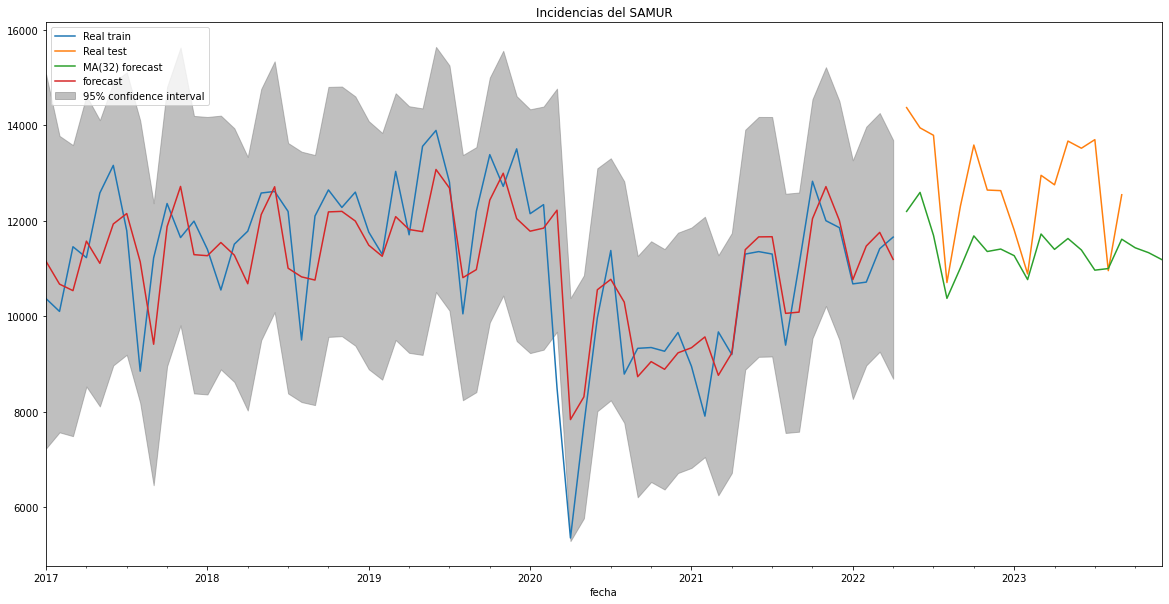

In [94]:
fig, ax = plt.subplots()
ax = train_samur.TOTAL.plot(ax=ax,figsize=(20,10), title = "Incidencias del SAMUR", label='Real train')
ax = test_samur.TOTAL.plot(ax=ax,figsize=(20,10), title = "Incidencias del SAMUR", label='Real test')
model_ma_samur = ARIMA(train_samur.TOTAL, order=(0,0,32))
results_ma_samur = model_ma_samur.fit()
results_mafore_samur = results_ma_samur.forecast(steps=20)
ax = results_mafore_samur.plot(ax=ax,label='MA(32) forecast')
plot_predict(results_ma_samur, dynamic=False,ax=ax)

plt.legend(loc="upper left")
plt.show()

### ARIMA

Como hemos visto que es necesario integrar la serie, prescindimos de probar modelos ARMA y pasamos directamente a probar con los modelos ARIMA.

In [95]:
model_arima_samur_1_int = ARIMA(train_samur.TOTAL, order=(12,1,12))
model_arima_samur_2_int = ARIMA(train_samur.TOTAL, order=(17,2,15))

results_arima_samur_1_int = model_arima_samur_1_int.fit()
sts.adfuller(results_arima_samur_1_int.resid)

(-11.615322780024611,
 2.456881319423051e-21,
 0,
 63,
 {'1%': -3.5386953618719676,
  '5%': -2.9086446751210775,
  '10%': -2.591896782564878},
 870.7202180120008)

In [96]:
results_arima_samur_2_int = model_arima_samur_2_int.fit()
sts.adfuller(results_arima_samur_2_int.resid)

(-5.295997539787968,
 5.581157603612137e-06,
 10,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 910.3178416992342)

Se toman como valores de _p_ y _q_ los valores respectivos de AR y MA, mientras que para la variable de _d_, se considerarán hasta 2 integraciones, pues con ella conseguimos que la serie sea estacionaria, aunque se corre el riesgo de que se pierda mucha información.

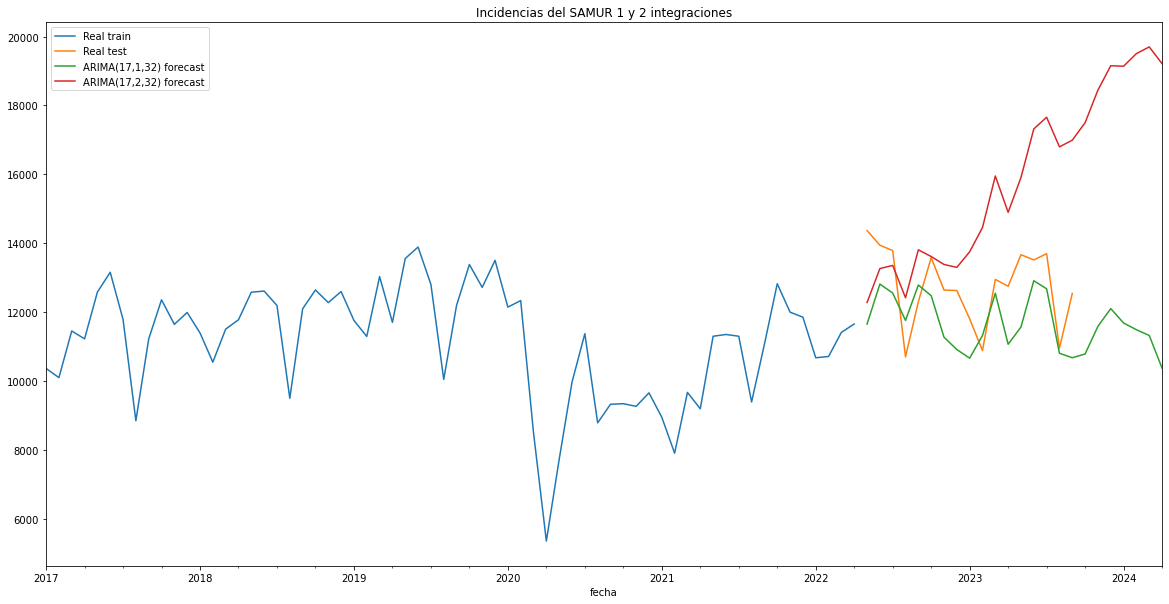

In [97]:
fig, ax = plt.subplots()
ax = train_samur.TOTAL.plot(ax=ax,figsize=(20,10), title = "Incidencias del SAMUR con 1 y 2 integraciones", label='Real train')
ax = test_samur.TOTAL.plot(ax=ax,figsize=(20,10), title = "Incidencias del SAMUR 1 y 2 integraciones", label='Real test')

model_arima_1_ints_samur = ARIMA(train_samur.TOTAL, order=(17,1,32))
results_arma_samur = model_arima_1_ints_samur.fit()
results_armafore_samur = results_arma_samur.forecast(steps=24)

model_arima_2_ints_samur = ARIMA(train_samur.TOTAL, order=(17,2,32))
results_arima_samur = model_arima_2_ints_samur.fit()
results_arimafore_samur = results_arima_samur.forecast(steps=24)

ax = results_armafore_samur.plot(ax=ax,label='ARIMA(17,1,32) forecast')
ax = results_arimafore_samur.plot(ax=ax,label='ARIMA(17,2,32) forecast')
plt.legend(loc="upper left")
plt.show()

Como podemos ver, ARIMA con dos integraciones no aproxima bien la serie ya que crea una tendencia ascendente. Por ello, guardamos las predicciones del modelo ARIMA con una integración para usarlo posteriormente como variable exógena.

In [98]:
samur_mejores = results_armafore_samur

# Estudio de los datos de la POLICÍA

In [99]:
fig = px.bar(policias_total, x=policias_total.index, y='TOTAL', title='Actuaciones de la policía')
fig.show()

In [100]:
circular, tendencia = hpfilter(policias_total['TOTAL'], lamb=1600)
policias_total['tendencia'] = tendencia

fig = px.line(policias_total, x=policias_total.index, y=['TOTAL', 'tendencia'], title='tendencia')
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()

In [101]:
df_policia = policias_total.copy()

## Prueba de Dickey Fuller

In [102]:
sts.adfuller(df_policia.TOTAL)

(-5.08734038511698,
 1.4864409109387005e-05,
 1,
 79,
 {'1%': -3.5159766913976376,
  '5%': -2.898885703483903,
  '10%': -2.5866935058484217},
 1142.1007780943546)

El p-valor es menor a 0.05, por lo que sugiere que la serie es estacionaria.

## Estudio de Autocorrelación

#### ACF

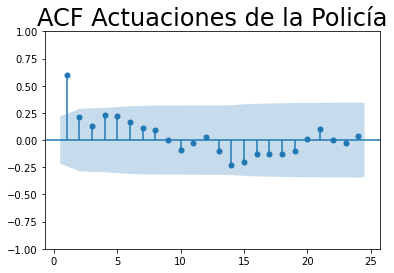

In [103]:
sgt.plot_acf(df_policia.TOTAL, lags = 24, zero = False)
plt.title("ACF Actuaciones de la Policía", size = 24)
plt.show()

#### PACF

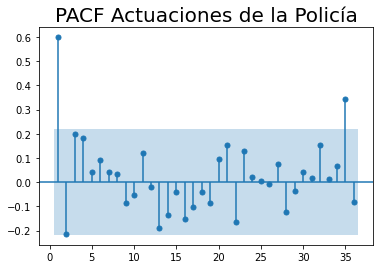

In [104]:
sgt.plot_pacf(df_policia.TOTAL, lags = 36, zero = False, method = ('ols'))
plt.title("PACF Actuaciones de la Policía", size = 20)
plt.autoscale()
plt.show()

## AR

In [105]:
size = int(len(df_policia)*0.8)
train_policia, test_policia = df_policia.iloc[:size], df_policia.iloc[size:]

In [106]:
rango_policia = range(0,30)

In [107]:
ModelArima_policia=dict()
for x in rango_policia:
  model_ar_policia = ARIMA(train_policia.TOTAL, order=(x,0,0))
  results_ar_policia = model_ar_policia.fit()
  results_arfore_policia = results_ar_policia.forecast(steps=len(test_policia.TOTAL))
  ModelArima_policia["AR("+str(x)+")"] = results_arfore_policia

  error = mean_squared_error(test_policia.TOTAL, results_arfore_policia)
  print("AR("+str(x)+") \t LLF:"+str(results_ar_policia.llf)+"     \t AIC:"+str(results_ar_policia.aic)+"      \t BIC:"+str(results_ar_policia.bic)+"     \t ERROR:"+str(error))

AR(0) 	 LLF:-563.6035491970858     	 AIC:1131.2070983941717      	 BIC:1135.524864560891     	 ERROR:977694.7913703705
AR(1) 	 LLF:-549.1397905709407     	 AIC:1104.2795811418814      	 BIC:1110.7562303919603     	 ERROR:1019426.1456078063
AR(2) 	 LLF:-547.9887452716428     	 AIC:1103.9774905432855      	 BIC:1112.6130228767242     	 ERROR:905289.1318534026
AR(3) 	 LLF:-545.7397223632004     	 AIC:1101.4794447264007      	 BIC:1112.273860143199     	 ERROR:1188673.007288362
AR(4) 	 LLF:-544.453719765051     	 AIC:1100.907439530102      	 BIC:1113.86073803026     	 ERROR:1416283.6254408816
AR(5) 	 LLF:-544.4361731381587     	 AIC:1102.8723462763173      	 BIC:1117.984527859835     	 ERROR:1428714.6111219558
AR(6) 	 LLF:-544.3681001488497     	 AIC:1104.7362002976995      	 BIC:1122.007264964577     	 ERROR:1409413.1533030765
AR(7) 	 LLF:-544.3563719874572     	 AIC:1106.7127439749145      	 BIC:1126.1426917251515     	 ERROR:1398330.4453828328
AR(8) 	 LLF:-544.3857875794969     	 AIC:11

In [108]:
valores_policia = [7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]

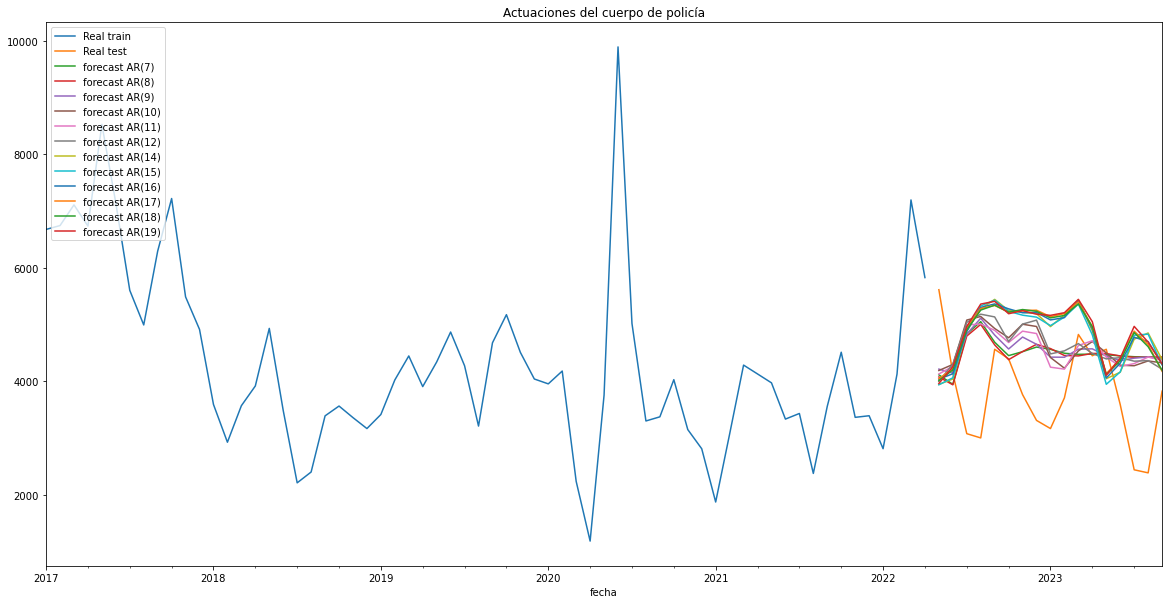

In [109]:
train_policia.TOTAL.plot(figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real train')
test_policia.TOTAL.plot(label='Real test')
for x in valores_policia:
   ModelArima_policia["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

Mostramos algún resultado obtenido que consideramos mejor.

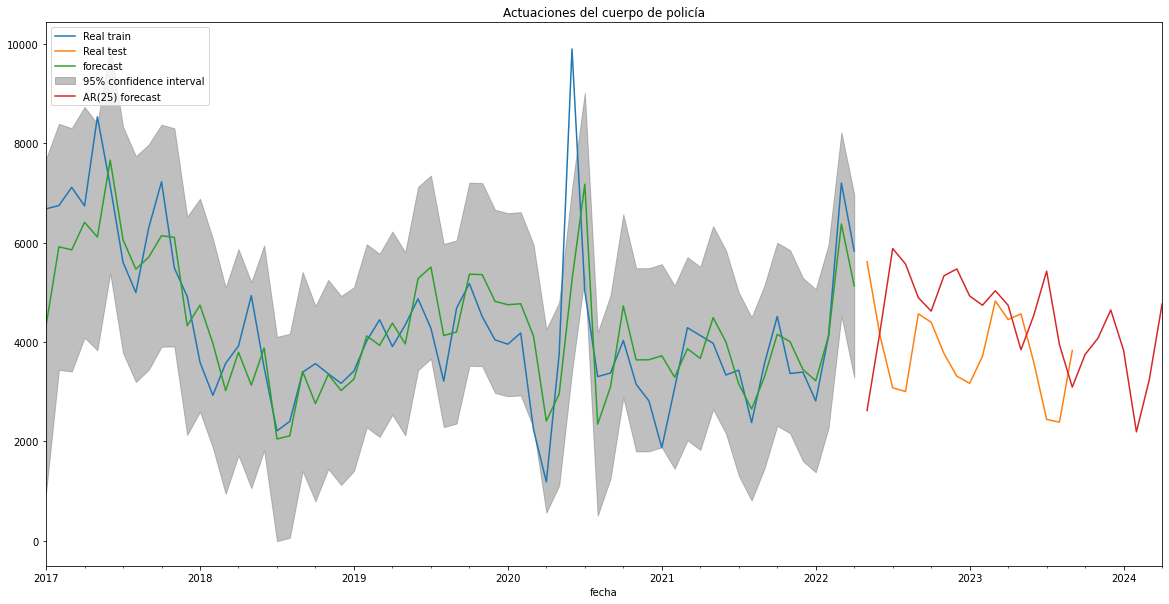

In [110]:
fig, ax = plt.subplots()
ax = train_policia.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real train')
ax = test_policia.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real test')
model_ar_policia = ARIMA(train_policia.TOTAL, order=(25,0,0))
results_ar_policia = model_ar_policia.fit()
results_arfore_policia = results_ar_policia.forecast(steps=24)

plot_predict(results_ar_policia, dynamic=False,ax=ax)
ax = results_arfore_policia.plot(ax=ax, label='AR(25) forecast')
plt.legend(loc="upper left")
plt.show()

## MA

In [111]:
ModelArima_policia=dict()
results_maprey=None


def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p


for x in rango_policia:
  model_ma_policia = ARIMA(train_policia.TOTAL, order=(0,0,x))
  results_ma_policia = model_ma_policia.fit()
  results_mafore_policia = results_ma_policia.forecast(steps=len(test_policia.TOTAL))
  ModelArima_policia["MA("+str(x)+")"] = results_mafore_policia

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma_policia))

  results_maprey=results_ma_policia

  print("MA("+str(x)+") \t LLF:"+str(results_ma_policia.llf)+"     \t AIC:"+str(results_ma_policia.aic)+"      \t BIC:"+str(results_ma_policia.bic)+"     \t LLR test p-value:"+str(error))

MA(0) 	 LLF:-563.6035491970858     	 AIC:1131.2070983941717      	 BIC:1135.524864560891     	 LLR test p-value:None
MA(1) 	 LLF:-549.3890128456264     	 AIC:1104.7780256912529      	 BIC:1111.2546749413318     	 LLR test p-value:0.0
MA(2) 	 LLF:-547.0254614517436     	 AIC:1102.0509229034872      	 BIC:1110.686455236926     	 LLR test p-value:0.03
MA(3) 	 LLF:-547.097753548207     	 AIC:1104.195507096414      	 BIC:1114.9899225132124     	 LLR test p-value:1.0
MA(4) 	 LLF:-546.6569951168077     	 AIC:1105.3139902336154      	 BIC:1118.2672887337735     	 LLR test p-value:0.348
MA(5) 	 LLF:-545.8761857948474     	 AIC:1105.7523715896948      	 BIC:1120.8645531732125     	 LLR test p-value:0.211
MA(6) 	 LLF:-545.0477075423391     	 AIC:1106.0954150846783      	 BIC:1123.3664797515557     	 LLR test p-value:0.198
MA(7) 	 LLF:-544.8592867800928     	 AIC:1107.7185735601856      	 BIC:1127.1485213104227     	 LLR test p-value:0.539
MA(8) 	 LLF:-544.8208113765706     	 AIC:1109.641622753141

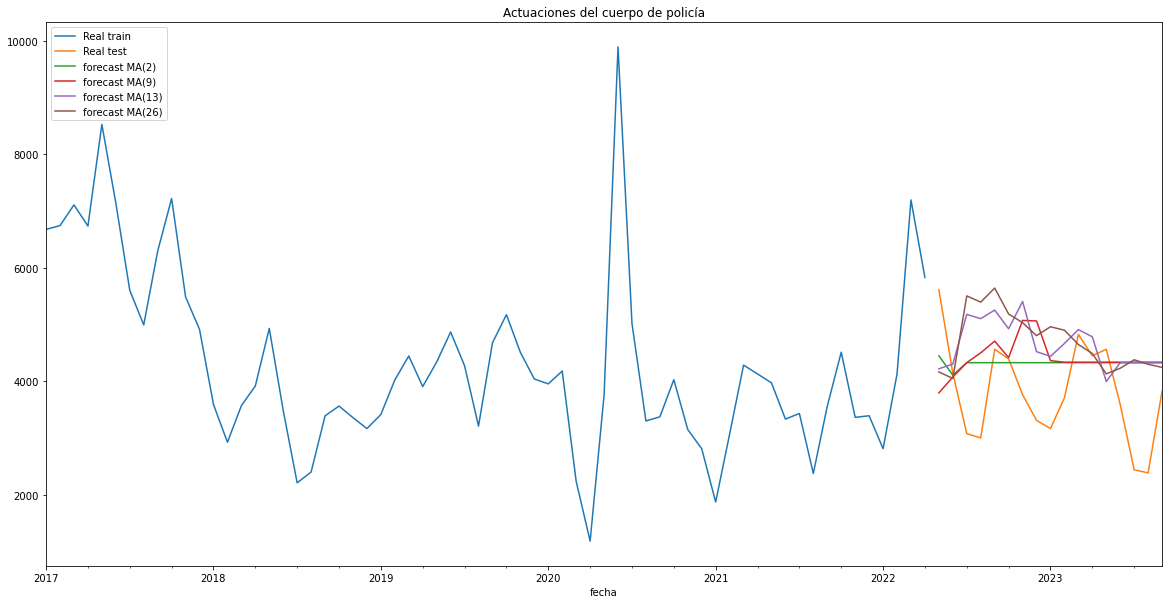

In [112]:
candidatos = [2, 9, 13, 26]

train_policia.TOTAL.plot(figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real train')
test_policia.TOTAL.plot(label='Real test')
for x in candidatos:
   ModelArima_policia["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

In [113]:
ModelArima_policia = dict()
results_maprey = None

for x in candidatos:
  model_ma_policia = ARIMA(train_policia.TOTAL, order=(0,0,x))
  results_ma_policia = model_ma_policia.fit()
  results_mafore_policia = results_ma_policia.forecast(steps=len(test_policia.TOTAL))
  ModelArima_policia["MA("+str(x)+")"] = results_mafore_policia

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma_policia))

  results_maprey=results_ma_policia

  print("MA("+str(x)+") \t LLF:"+str(results_ma_policia.llf)+"     \t AIC:"+str(results_ma_policia.aic)+"      \t BIC:"+str(results_ma_policia.bic)+"     \t LLR test p-value:"+str(error))

MA(2) 	 LLF:-547.0254614517436     	 AIC:1102.0509229034872      	 BIC:1110.686455236926     	 LLR test p-value:None
MA(9) 	 LLF:-542.843942286542     	 AIC:1107.687884573084      	 BIC:1131.4355984900403     	 LLR test p-value:0.004
MA(13) 	 LLF:-540.2302772006854     	 AIC:1110.4605544013707      	 BIC:1142.8438006517658     	 LLR test p-value:0.022
MA(26) 	 LLF:-540.3134395182433     	 AIC:1136.6268790364866      	 BIC:1197.0756053705575     	 LLR test p-value:1.0


Mostramos los mejores resultados obtenidos.

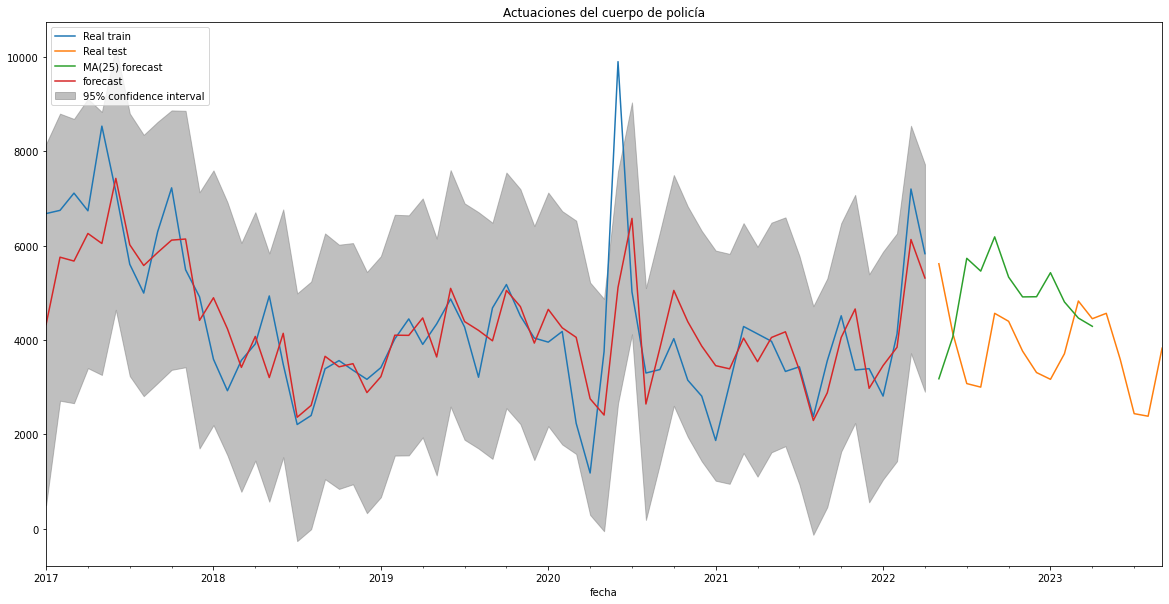

In [114]:
fig, ax = plt.subplots()
ax = train_policia.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real train')
ax = test_policia.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real test')
model_ma_policia = ARIMA(train_policia.TOTAL, order=(0,0,25))
results_ma_policia = model_ma_policia.fit()
results_mafore_policia = results_ma_policia.forecast(steps=12)
ax = results_mafore_policia.plot(ax=ax,label='MA(25) forecast')
plot_predict(results_ma_policia, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

## ARMA

Al ser una serie estacionaria, no se realizarán pruebas con modelos ARIMA y se procederá a analizar los resultados obtenidos con modelos ARMA. Justo el caso contrario a la situación de la serie del SAMUR.

In [115]:
model_arma_1_1_policia = ARIMA(train_policia.TOTAL, order=(18,0,12))
results_arma_1_1_policia = model_arma_1_1_policia.fit()
sts.adfuller(results_arma_1_1_policia.resid)

(-5.495495402887117,
 2.128063747347672e-06,
 0,
 63,
 {'1%': -3.5386953618719676,
  '5%': -2.9086446751210775,
  '10%': -2.591896782564878},
 911.013490823243)

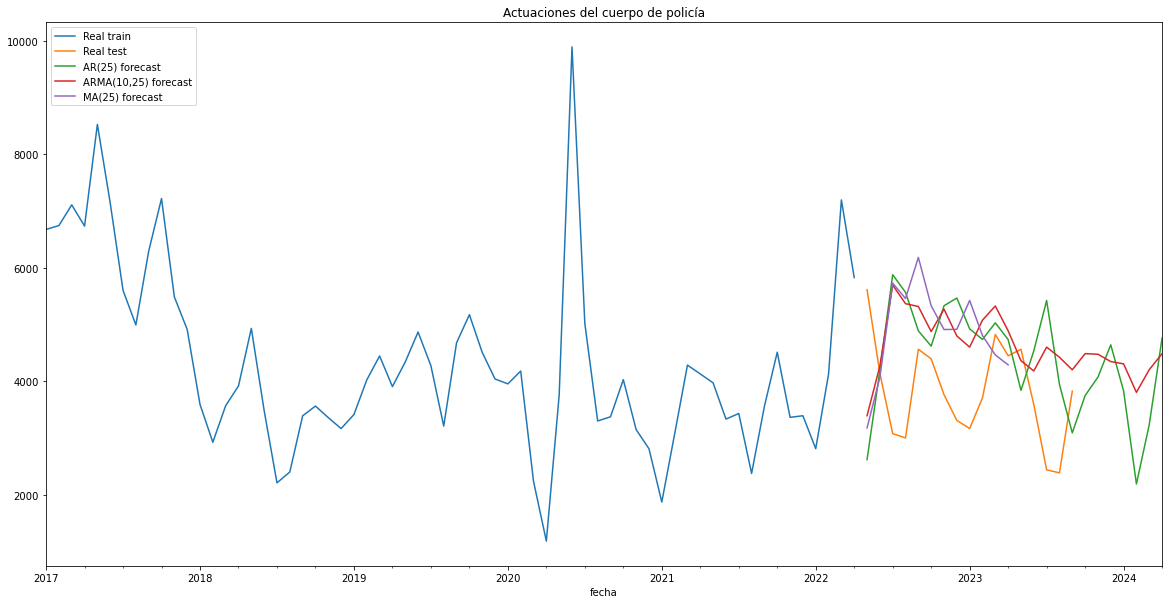

In [116]:
fig, ax = plt.subplots()

ax = train_policia.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real train')
ax = test_policia.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones del cuerpo de policía", label='Real test')
model_arma_policia = ARIMA(
    train_policia.TOTAL, order=(10, 0, 25))
results_arma_policia = model_arma_policia.fit()
results_armafore_policia = results_arma_policia.forecast(steps=24)
ax = results_arfore_policia.plot(ax=ax, label='AR(25) forecast')
ax = results_armafore_policia.plot(ax=ax,label='ARMA(10,25) forecast')
ax = results_mafore_policia.plot(ax=ax,label='MA(25) forecast')
plt.legend(loc="upper left")
plt.show()

En este caso, el modelo ARMA consigue aproximar las subidas y bajadas de la serie original, aunque las oscilaciones son menos pronunciadas y parece estar desfasada en algunos momentos. A pesar de ello, es la mejor aproximación que tenemos y la guardamos para usarla como exógena posteriormente.

In [117]:
policia_mejores = results_armafore_policia

# Modelos SARIMAX

A continuacion intentaremos usar SARIMAX para mejorar las predicciones anteriores sobre la serie de los bomberos.

## Usando los datos de la policía como variable exógena

Debido a que la serie indica ser estacionaria, es preferible probar con modelos ARMA a ARIMA. Por otro lado, se emplearán modelos MAX que nos permitan la agregación de componentes exógenas, que en nuestro caso son los cuerpos de policía y SAMUR.

Además, en caso de ser necesario se incorporará una componente estacional temporal (Seasional).

Introducimos como variables exógenas los valores de las actuaciones de policía para ver la posible mejora.

In [118]:
policia_mejores = pd.DataFrame(policia_mejores)
policia_mejores.rename(columns={'predicted_mean': 'TOTAL'}, inplace=True)

pred_policia = pd.concat([train_policia.drop(columns=['tendencia']), policia_mejores], axis=0)
pred_policia

TOTAL
2017-01-01  6677.000000
2017-02-01  6745.000000
2017-03-01  7110.000000
2017-04-01  6736.000000
2017-05-01  8529.000000
...                 ...
2023-12-01  4347.269229
2024-01-01  4306.680493
2024-02-01  3803.463378
2024-03-01  4204.489109
2024-04-01  4485.844080

[88 rows x 1 columns]

Para poder usar estos modelos, es necesario ampliar los datos de train de los bomberos con los índices a predecir y sus respectivos valores como np.NaN

In [119]:
train.head(1).index

DatetimeIndex(['2017-08-01'], dtype='datetime64[ns]', name='fecha', freq=None)

In [120]:
train_aux = pd.DataFrame({'TOTAL': np.NaN}, index=pd.date_range('2022-07-01', periods=29, freq='MS'))

# Dataframe con indices de las prediccion y valores NaN en esos indices

train_aux  = pd.concat([train.drop(columns=['tendencia']), train_aux], axis=0) 

pred_policia.index = train_aux.index # Ponemos los indices correctos

In [121]:
model_sarimax = SARIMAX(train_aux.TOTAL, exog=pred_policia.TOTAL,order=(0,0,0),seasonal_order=(1,0,1,12),enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      TOTAL   No. Observations:                   88
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -460.760
Date:                    Sun, 21 Jan 2024   AIC                            929.520
Time:                            19:45:12   BIC                            939.429
Sample:                        08-01-2017   HQIC                           933.512
                             - 11-01-2024                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TOTAL          0.1849      0.028      6.505      0.000       0.129       0.241
ar.S.L12       0.9948      0.021     47.428      0.000       0.954       1.036
ma.S.L12      -0.7971      0.366     -2.180      0.029      -1.514      -0.080
sigma2      2.325e+05   8.65e+04      2.687      0.007    6.29e+04    4.02e+05
===================================================================================
Ljung-Box (L1) (Q):                  15.19   Jarque-Bera (JB):                12.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

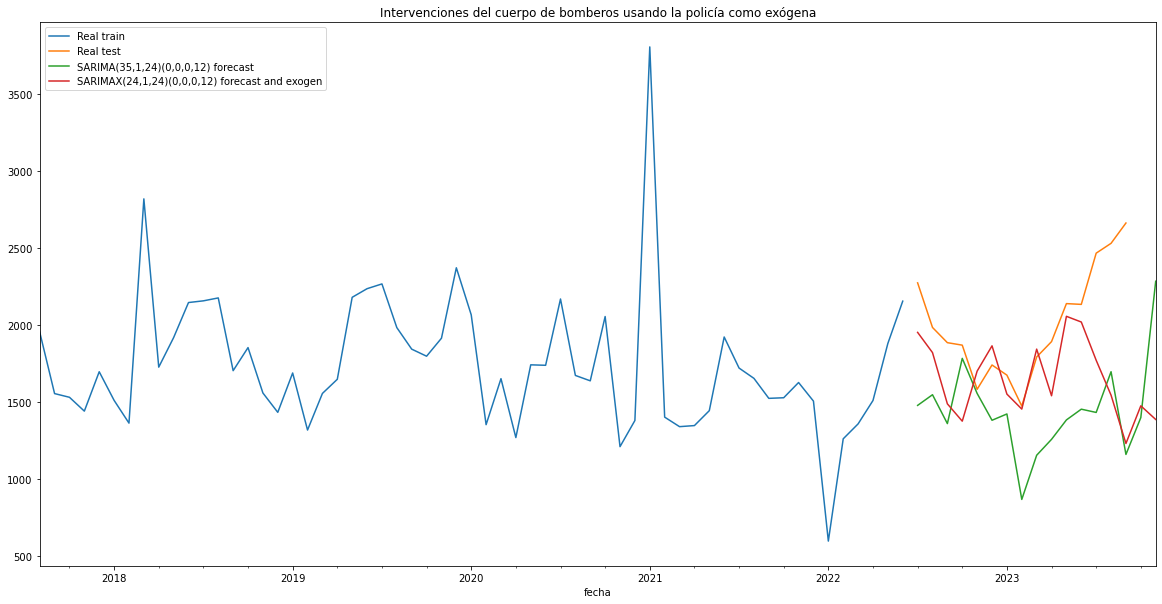

In [122]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando la policía como exógena", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando la policía como exógena", label='Real test')


model_sarima = SARIMAX(train.TOTAL, order=(35,1,24),seasonal_order=(0,0,0,12),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=17)


model_sarimax_policia = SARIMAX(train_aux.TOTAL, exog=pred_policia.TOTAL, order=(24,1,24),
                        seasonal_order=(0,0,0,12), enforce_invertibility=False)
sarimax_results_policia = model_sarimax_policia.fit()
results_sarimaxfore_policia = sarimax_results_policia.forecast(steps=17,exog=test_policia.TOTAL)

results_sarimaxfore_policia.index = results_sarimafore.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(35,1,24)(0,0,0,12) forecast')
ax = results_sarimaxfore_policia.plot(ax=ax,label='SARIMAX(24,1,24)(0,0,0,12) forecast and exogen')
plt.legend(loc="upper left")
plt.show()

La predicción no es exageradamente buena, pero tampoco es tan mala como alguna otra que hemos obtenido anteriormente. Vemos como la predicción del modelo SARIMAX aproxima muy bien el principio y el final de los datos de test, pero en la parte final se separa mucho, mientras que la predicción del modelo SARIMA es justo al revés, consigue obtener el final ascendente como la serie original.

## Usando los datos del Samur como variable exógena

Repetimos el proceso anterior con los datos del SAMUR.

In [123]:
samur_mejores = pd.DataFrame(samur_mejores)
samur_mejores.rename(columns={'predicted_mean': 'TOTAL'}, inplace=True)

pred_samur = pd.concat([train_samur.drop(columns=['tendencia', 'returns', 'returns_returns']), samur_mejores], axis=0)
pred_samur

TOTAL
2017-01-01  10368.000000
2017-02-01  10100.000000
2017-03-01  11455.000000
2017-04-01  11226.000000
2017-05-01  12582.000000
...                  ...
2023-12-01  12103.903517
2024-01-01  11685.667808
2024-02-01  11491.020670
2024-03-01  11323.750574
2024-04-01  10376.278068

[88 rows x 1 columns]

In [124]:
train.head(1).index

DatetimeIndex(['2017-08-01'], dtype='datetime64[ns]', name='fecha', freq=None)

In [125]:
pred_samur.index = train_aux.index # Ponemos los indices correctos

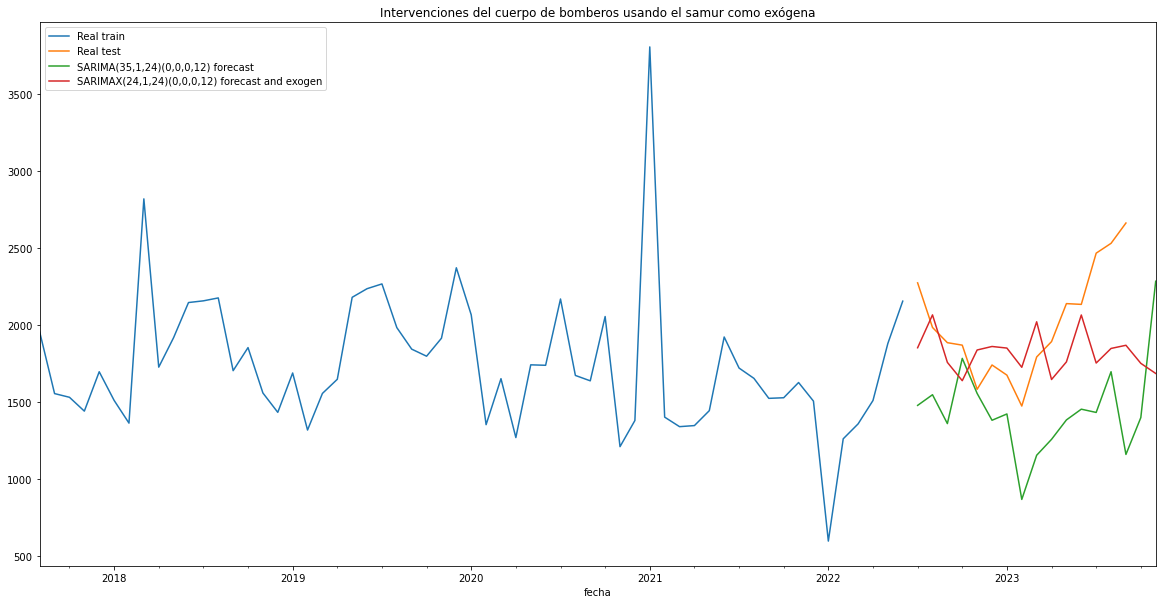

In [126]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando el samur como exógena", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando el samur como exógena", label='Real test')

model_sarimax_samur = SARIMAX(train_aux.TOTAL, exog=pred_samur.TOTAL, order=(24,1,24),
                        seasonal_order=(0,0,0,12), enforce_invertibility=False)
sarimax_results_samur = model_sarimax_samur.fit()
results_sarimaxfore_samur = sarimax_results_samur.forecast(steps=17,exog=test_samur.TOTAL)

results_sarimaxfore_samur.index = results_sarimafore.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(35,1,24)(0,0,0,12) forecast')
ax = results_sarimaxfore_samur.plot(ax=ax,label='SARIMAX(24,1,24)(0,0,0,12) forecast and exogen')
plt.legend(loc="upper left")
plt.show()

Obtenemos unos resultados muy parecidos al modelo anterior. Sin embargo, la predicción del modelo SARIMAX no cae tan pronunciadamente como antes luego consideramos que es una de las mejores predicciones que hemos obtenido hasta el momento.

## Usando los datos de la policía y del Samur como variables exógenas

Por último, probamos a usar ambas variables como exógenas para comprobar los resultados.

La forma de introducir dos variables como exógenas en crear un dataframe con dos columnas y con los mismos índices que los que queremos predecir.

In [127]:
policia_samur = pd.concat([pred_policia.rename(columns={'TOTAL': 'TOTAL_policia'}), pred_samur.rename(columns={'TOTAL': 'TOTAL_samur'})], axis=1)
policia_samur

TOTAL_policia   TOTAL_samur
2017-08-01    6677.000000  10368.000000
2017-09-01    6745.000000  10100.000000
2017-10-01    7110.000000  11455.000000
2017-11-01    6736.000000  11226.000000
2017-12-01    8529.000000  12582.000000
...                   ...           ...
2024-07-01    4347.269229  12103.903517
2024-08-01    4306.680493  11685.667808
2024-09-01    3803.463378  11491.020670
2024-10-01    4204.489109  11323.750574
2024-11-01    4485.844080  10376.278068

[88 rows x 2 columns]

In [128]:
model_sarimax = SARIMAX(train_aux.TOTAL, exog=policia_samur,order=(0,0,0),seasonal_order=(1,0,1,12),enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      TOTAL   No. Observations:                   88
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood                -444.736
Date:                    Sun, 21 Jan 2024   AIC                            899.472
Time:                            19:45:29   BIC                            911.859
Sample:                        08-01-2017   HQIC                           904.462
                             - 11-01-2024                                         
Covariance Type:                      opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
TOTAL_policia     0.1017      0.030      3.445      0.001       0.044       0.159
TOTAL_samur       0.1161      0.014      8.101      0.000       0.088       0.144
ar.S.L12         -0.9992      0.033    -29.979      0.000      -1.065      -0.934
ma.S.L12          0.9852      0.328      3.004      0.003       0.342       1.628
sigma2         1.877e+05   1.97e-06   9.54e+10      0.000    1.88e+05    1.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):                64.84
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.02e+27. Standard errors may be unstable.
"""

In [129]:
test_policia_samur = pd.concat([pd.DataFrame(test_policia.TOTAL).rename(columns={'TOTAL': 'TOTAL_policia'}), pd.DataFrame(test_samur.TOTAL).rename(columns={'TOTAL': 'TOTAL_samur'})], axis=1)
test_policia_samur = test_policia_samur[:-2]
test_policia_samur

TOTAL_policia  TOTAL_samur
fecha                                 
2022-05-01         5614.0      14369.0
2022-06-01         4141.0      13945.0
2022-07-01         3076.0      13789.0
2022-08-01         3001.0      10705.0
2022-09-01         4564.0      12303.0
2022-10-01         4395.0      13585.0
2022-11-01         3764.0      12642.0
2022-12-01         3310.0      12630.0
2023-01-01         3166.0      11805.0
2023-02-01         3708.0      10886.0
2023-03-01         4825.0      12951.0
2023-04-01         4450.0      12752.0
2023-05-01         4564.0      13668.0
2023-06-01         3589.0      13518.0
2023-07-01         2439.0      13698.0

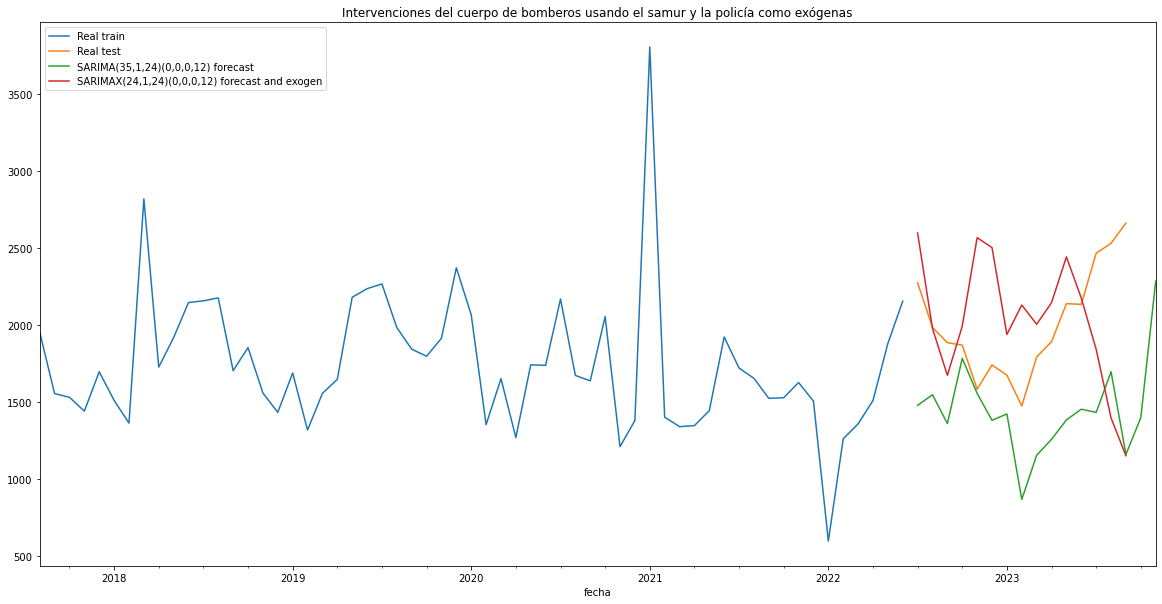

In [130]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando el samur y la policía como exógenas", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando el samur y la policía como exógenas", label='Real test')

model_sarimax_mix = SARIMAX(train_aux.TOTAL, exog=policia_samur, order=(24,1,24),
                        seasonal_order=(0,0,0,12), enforce_invertibility=False)
sarimax_results_mix = model_sarimax_mix.fit()
results_sarimaxfore_mix = sarimax_results_mix.forecast(steps=15,exog=test_policia_samur)



results_sarimaxfore_mix.index = results_sarimafore[:-2].index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(35,1,24)(0,0,0,12) forecast')
ax = results_sarimaxfore_mix.plot(ax=ax,label='SARIMAX(24,1,24)(0,0,0,12) forecast and exogen')
plt.legend(loc="upper left")
plt.show()

Como podemos ver, las predicciones parecen estar más cerca esta vez, aunque no consiguen replicar las oscilaciones igual de bien que modelos anteriores. Sin embargo, son unos resultados a tener en cuenta cuando realicemos una comparación de todos los resultados.

# Pruebas autoarima/autosarimax

Realizamos algunas pruebas con Autoarima/autosarimax para comprobar si hay valores que no hemos usado que ayuden a mejorar las predicciones

In [131]:
variables_exogenas = ['TOTAL_policia', 'TOTAL_samur']

model = pm.auto_arima(train.TOTAL,
                      exogenous = policia_samur[variables_exogenas],
                      start_p=0,
                      start_q=0,
                      test='adf',
                      max_p=34, max_q=25, max_d=2, # maximo p, q, d
                      m=24, # Tamaño de la estacionalidad
                      d=None,# permite fijar la integracion
                      seasonal=True, # Si busca estacionalida en ARIMA
                      trace=True, #Imprimir log del proceso
                      error_action='warn', #mostrar errorres?
                      suppress_warnings=True,
                      stepwise=True)

model.fit(train.TOTAL, exogenous = policia_samur[variables_exogenas])

forecast = model.predict(n_periods=len(test.TOTAL), exogenous = test_policia_samur[variables_exogenas])
test['forecast'] = forecast

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=542.628, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=540.479, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=540.924, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=543.844, Time=0.20 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=539.919, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[24]             : AIC=540.140, Time=0.13 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=inf, Time=2.73 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=1.07 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Time=0.63 sec
 AR

<AxesSubplot:xlabel='fecha'>

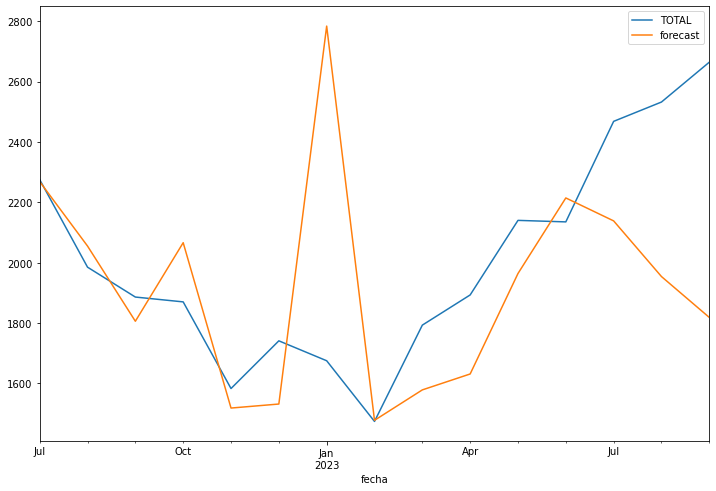

In [132]:
# Mostramos el drafico de test y forecast
test[['TOTAL', 'forecast']].plot(figsize=(12,8))

In [133]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   59
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 24)   Log Likelihood                -265.959
Date:                            Sun, 21 Jan 2024   AIC                            539.919
Time:                                    19:45:53   BIC                            546.024
Sample:                                08-01-2017   HQIC                           542.001
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5082      0.157     -3.230      0.001      -0.816      -0.200
ar.L2         -0.2744      0.157   

In [134]:
model_sarimax_policia

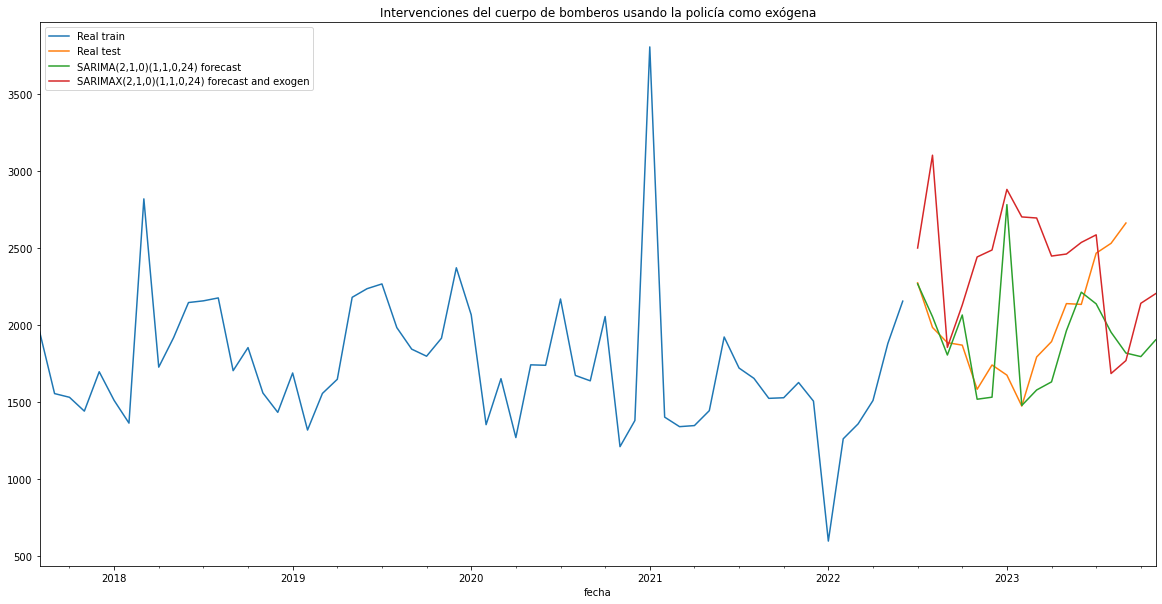

In [135]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando la policía como exógena", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando la policía como exógena", label='Real test')


model_autosarima = SARIMAX(train.TOTAL, order=(2,1,0),seasonal_order=(1,1,0,24),enforce_invertibility=False)
results_autosarima = model_autosarima.fit()
results_autosarimafore = results_autosarima.forecast(steps=17)


model_autosarimax_policia = SARIMAX(train_aux.TOTAL, exog=pred_policia.TOTAL, order=(2,1,0),seasonal_order=(1,1,0,24), enforce_invertibility=False)
autosarimax_results_policia = model_autosarimax_policia.fit()
results_autosarimaxfore_policia = autosarimax_results_policia.forecast(steps=17,exog=test_policia.TOTAL)

results_autosarimaxfore_policia.index = results_autosarimafore.index

ax = results_autosarimafore.plot(ax=ax,label='SARIMA(2,1,0)(1,1,0,24) forecast')
ax = results_autosarimaxfore_policia.plot(ax=ax,label='SARIMAX(2,1,0)(1,1,0,24) forecast and exogen')
plt.legend(loc="upper left")
plt.show()

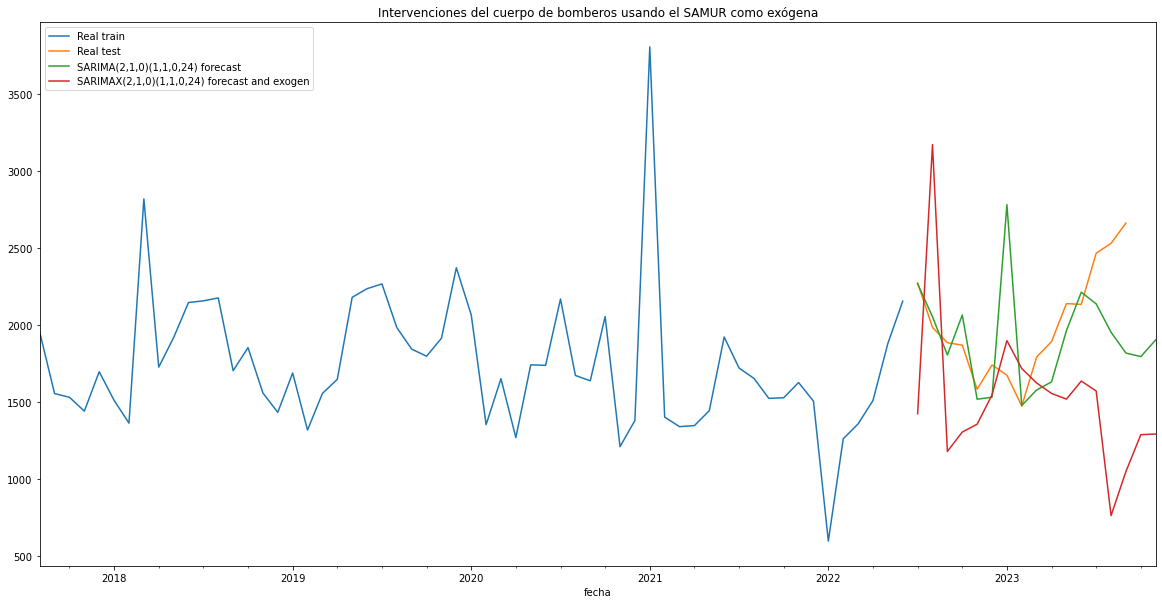

In [136]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando el SAMUR como exógena", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Intervenciones del cuerpo de bomberos usando el SAMUR como exógena", label='Real test')


model_autosarima = SARIMAX(train.TOTAL, order=(2,1,0),seasonal_order=(1,1,0,24),enforce_invertibility=False)
results_autosarima = model_autosarima.fit()
results_autosarimafore = results_autosarima.forecast(steps=17)


model_autosarimax_policia = SARIMAX(train_aux.TOTAL, exog=pred_samur.TOTAL, order=(2,1,0),seasonal_order=(1,1,0,24), enforce_invertibility=False)
autosarimax_results_policia = model_autosarimax_policia.fit()
results_autosarimaxfore_policia = autosarimax_results_policia.forecast(steps=17,exog=test_policia.TOTAL)

results_autosarimaxfore_policia.index = results_autosarimafore.index

ax = results_autosarimafore.plot(ax=ax,label='SARIMA(2,1,0)(1,1,0,24) forecast')
ax = results_autosarimaxfore_policia.plot(ax=ax,label='SARIMAX(2,1,0)(1,1,0,24) forecast and exogen')
plt.legend(loc="upper left")
plt.show()

Los modelos probados con autoarima/autosarimax no han dado mejores resultados que los que se han hecho previamente, por tanto nos quedamos con los resultados anteriores.

# Mejores predicciones

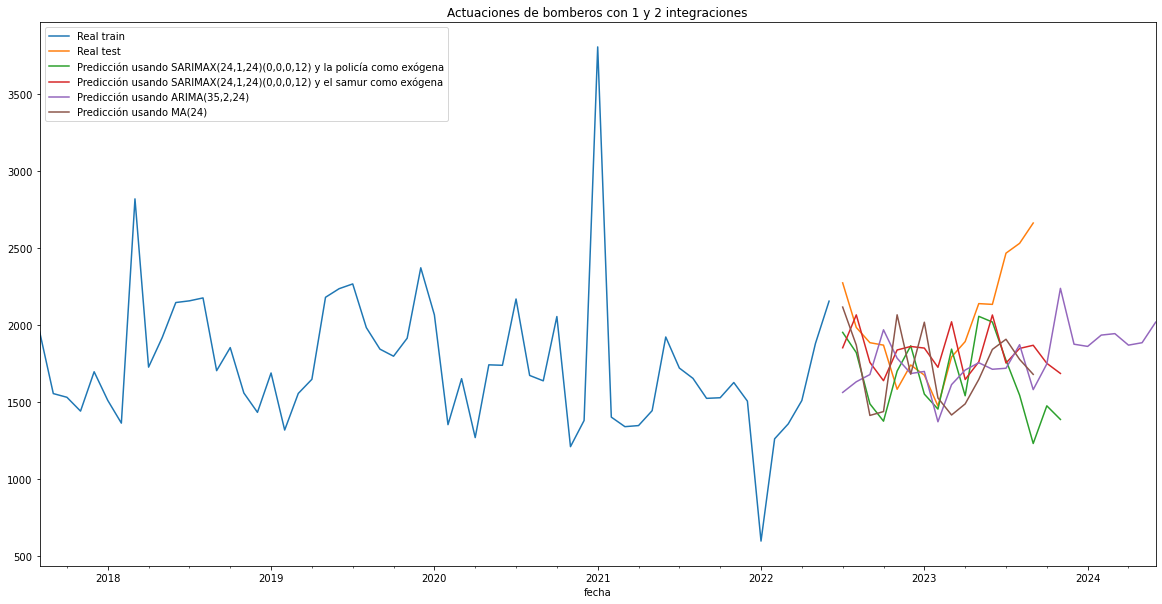

In [137]:
fig, ax = plt.subplots()
ax = train.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos con 1 y 2 integraciones", label='Real train')
ax = test.TOTAL.plot(ax=ax,figsize=(20,10), title = "Actuaciones de bomberos con 1 y 2 integraciones", label='Real test')

ax = results_sarimaxfore_policia.plot(ax=ax,label='Predicción usando SARIMAX(24,1,24)(0,0,0,12) y la policía como exógena')
ax = results_sarimaxfore_samur.plot(ax=ax,label='Predicción usando SARIMAX(24,1,24)(0,0,0,12) y el samur como exógena')
ax = results_arimafore_2_int.plot(ax=ax,label='Predicción usando ARIMA(35,2,24)')
ax = results_mafore.plot(ax=ax,label='Predicción usando MA(24)')

plt.legend(loc="upper left")
plt.show()

In [138]:
# Predicciones SARIMAX con la policía como exógena
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=train.index, y=train['TOTAL'], mode='lines', name='Real train'))
fig1.add_trace(go.Scatter(x=test.index, y=test['TOTAL'], mode='lines', name='Real test'))
fig1.add_trace(go.Scatter(x=test.index, y=results_sarimaxfore_policia, mode='lines', name='Predicción SARIMAX con policía', line=dict(color='green')))
fig1.update_layout(title='Predicción usando SARIMAX(24,1,24)(0,0,0,12) y la policía como exógena', xaxis_title="Año", yaxis_title="Número de intervenciones", hovermode="x")

fig1.show()
# Predicciones SARIMAX con el Samur como exógena
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=train.index, y=train['TOTAL'], mode='lines', name='Real train'))
fig2.add_trace(go.Scatter(x=test.index, y=test['TOTAL'], mode='lines', name='Real test'))
fig2.add_trace(go.Scatter(x=test.index, y=results_sarimaxfore_samur, mode='lines', name='Predicción SARIMAX con Samur', line=dict(color='green')))
fig2.update_layout(title='Predicción usando SARIMAX(24,1,24)(0,0,0,12) y el Samur como exógena', xaxis_title="Año", yaxis_title="Número de intervenciones", hovermode="x")
fig2.show()

# Predicciones ARIMA
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=train.index, y=train['TOTAL'], mode='lines', name='Real train'))
fig3.add_trace(go.Scatter(x=test.index, y=test['TOTAL'], mode='lines', name='Real test'))
fig3.add_trace(go.Scatter(x=test.index, y=results_arimafore_2_int, mode='lines', name='Predicción ARIMA(35,2,24)', line=dict(color='green')))
fig3.update_layout(title="Predicción usando ARIMA(35,2,24)", xaxis_title="Año", yaxis_title="Número de intervenciones", hovermode="x")
fig3.show()

# Predicciones con MA
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=train.index, y=train['TOTAL'], mode='lines', name='Real train'))
fig4.add_trace(go.Scatter(x=test.index, y=test['TOTAL'], mode='lines', name='Real test'))
fig4.add_trace(go.Scatter(x=test.index, y=results_mafore, mode='lines', name='Predicción MA(24)', line=dict(color='green')))
fig4.update_layout(title="Predicción usando MA(24)", xaxis_title="Año", yaxis_title="Número de intervenciones", hovermode="x")
fig4.show()

# Predicciones SARIMAX con el Samur y la policía como exógenas
fig5 = go.Figure()
fig5.add_trace(go.Scatter(x=train.index, y=train['TOTAL'], mode='lines', name='Real train'))
fig5.add_trace(go.Scatter(x=test.index, y=test['TOTAL'], mode='lines', name='Real test'))
fig5.add_trace(go.Scatter(x=test.index, y=results_sarimaxfore_mix, mode='lines', name='Predicción SARIMAX con Samur y policía', line=dict(color='green')))
fig5.update_layout(title="Predicción usando SARIMAX(24,1,24)(0,0,0,12) y el SAMUR y la policía como exógenas", xaxis_title="Año", yaxis_title="Número de intervenciones", hovermode="x")
fig5.show()

Viendo los resultados de las predicciones podemos concluir que el cuerpo de policía no tiene un impacto positivo como variable exógena sobre la predicción del cuerpo de bomberos. Lo que es esperable pues las incidencias de los dos cuerpos no suelen estar correlacionados. En cambio, el samur si consigue ajustar las predicciones, aunque la diferencia entre las ellas, usando únicamente el cuerpo de bomberos o usando los datos del SAMUR como variable exógena no son muy notables.

In [139]:
# Calculamos el mae de las predicciones

mae_sarimax_policia = mean_absolute_error(test.TOTAL, results_sarimaxfore_policia[:15])
mae_sarimax_samur = mean_absolute_error(test.TOTAL, results_sarimaxfore_samur[:15])
mae_arima = mean_absolute_error(test.TOTAL, results_arimafore_2_int[:15])
mae_ma = mean_absolute_error(test.TOTAL, results_mafore[:15])
mae_sarimax_mix = mean_absolute_error(test.TOTAL, results_sarimaxfore_mix[:15])

print("MAE de la predicción SARIMAX con la policía como exógena: ", mae_sarimax_policia)
print("MAE de la predicción SARIMAX con el Samur como exógena: ", mae_sarimax_samur)
print("MAE de la predicción ARIMA: ", mae_arima)
print("MAE de la predicción MA: ", mae_ma)
print("MAE de la predicción SARIMAX con el Samur y la policía como exógenas: ", mae_sarimax_mix)

MAE de la predicción SARIMAX con la policía como exógena:  365.39300060350445
MAE de la predicción SARIMAX con el Samur como exógena:  318.8573467971864
MAE de la predicción ARIMA:  361.19782233415475
MAE de la predicción MA:  398.99827667728425
MAE de la predicción SARIMAX con el Samur y la policía como exógenas:  494.80034017828245


In [140]:
# Calculamos los errores mse de las predicciones

error_sarimax_policia = mean_squared_error(test.TOTAL, results_sarimaxfore_policia[:15])
error_sarimax_samur = mean_squared_error(test.TOTAL, results_sarimaxfore_samur[:15])
error_arima = mean_squared_error(test.TOTAL, results_arimafore_2_int[:15])
error_ma = mean_squared_error(test.TOTAL, results_mafore[:15])
error_sarimax_mix = mean_squared_error(test.TOTAL, results_sarimaxfore_mix[:15])

print("Error de la predicción SARIMAX con la policía como exógena: ", error_sarimax_policia)
print("Error de la predicción SARIMAX con el Samur como exógena: ", error_sarimax_samur)
print("Error de la predicción ARIMA: ", error_arima)
print("Error de la predicción MA: ", error_ma)
print("Error de la predicción SARIMAX con el Samur y la policía como exógenas: ", error_sarimax_mix)

Error de la predicción SARIMAX con la policía como exógena:  282607.47963678563
Error de la predicción SARIMAX con el Samur como exógena:  153313.31730917454
Error de la predicción ARIMA:  220006.98398613287
Error de la predicción MA:  219592.38998451002
Error de la predicción SARIMAX con el Samur y la policía como exógenas:  426328.58872201084


In [141]:
# Calculamos el rmse de las predicciones

rmse_sarimax_policia = sqrt(mean_squared_error(test.TOTAL, results_sarimaxfore_policia[:15]))
rmse_sarimax_samur = sqrt(mean_squared_error(test.TOTAL, results_sarimaxfore_samur[:15]))
rmse_arima = sqrt(mean_squared_error(test.TOTAL, results_arimafore_2_int[:15]))
rmse_ma = sqrt(mean_squared_error(test.TOTAL, results_mafore[:15]))
rmse_sarimax_mix = sqrt(mean_squared_error(test.TOTAL, results_sarimaxfore_mix[:15]))

print("RMSE de la predicción SARIMAX con la policía como exógena: ", rmse_sarimax_policia)
print("RMSE de la predicción SARIMAX con el Samur como exógena: ", rmse_sarimax_samur)
print("RMSE de la predicción ARIMA: ", rmse_arima)
print("RMSE de la predicción MA: ", rmse_ma)
print("RMSE de la predicción SARIMAX con el Samur y la policía como exógenas: ", rmse_sarimax_mix)

RMSE de la predicción SARIMAX con la policía como exógena:  531.6083893589205
RMSE de la predicción SARIMAX con el Samur como exógena:  391.5524451579565
RMSE de la predicción ARIMA:  469.0490208774909
RMSE de la predicción MA:  468.60686079539
RMSE de la predicción SARIMAX con el Samur y la policía como exógenas:  652.9384264400517


En caso de querer escoger una posible predicción escogeríamos SARIMAX(24,1,24)(0,0,0,12) y los datos del Samur como exógena, o la predicción usando ARIMA(35,2,24), ya que son los que mejor se aproximan a los resultados que estamos buscando. 